# Import libs

In [1]:
import multiprocessing
import pandas as pd

from datasets import load_dataset, concatenate_datasets
from nltk.tree import Tree
from nltk.grammar import Nonterminal

from typing import Dict, Optional, List

from tqdm import tqdm

from copy import deepcopy

from collections import defaultdict

/home/victoru/docs/ontonotesv5-extract-cfg/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Load dataset

In [3]:
ontonotes = load_dataset('conll2012_ontonotesv5', 'english_v12', cache_dir='.cache')

In [4]:
ontonotes

DatasetDict({
    train: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 10539
    })
    validation: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 1370
    })
    test: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 1200
    })
})

In [5]:
ontonotes = concatenate_datasets([ontonotes['train'], ontonotes['validation'], ontonotes['test']])
ontonotes

Dataset({
    features: ['document_id', 'sentences'],
    num_rows: 13109
})

# Preprocess trees

## Extract trees

In [6]:
ontn_sentc_tree = []

for documents in tqdm(ontonotes):
    for sentence in documents['sentences']:
        if sentence['parse_tree'] is not None:
            ontn_sentc_tree.append({'parse_tree': sentence['parse_tree'], 'words': sentence['words']})

100%|██████████| 13109/13109 [00:22<00:00, 593.50it/s] 


In [7]:
len(ontn_sentc_tree)

137036

## Find rare top cases

In [8]:
top_prods_dict = dict()
for elem in tqdm(ontn_sentc_tree):
    tree = Tree.fromstring(elem['parse_tree'])
    top_prod = str(tree.productions()[0])
    if top_prod in top_prods_dict.keys():
        top_prods_dict[top_prod] += 1
    else:
        top_prods_dict[top_prod] = 1
top_prods_dict

100%|██████████| 137036/137036 [00:11<00:00, 11820.97it/s]


{'TOP -> SBARQ': 2238,
 'TOP -> S': 115580,
 'TOP -> NP': 3662,
 'TOP -> SINV': 2560,
 'TOP -> INTJ': 4711,
 'TOP -> SQ': 2233,
 'TOP -> X': 329,
 'TOP -> SBAR': 486,
 'TOP -> FRAG': 4065,
 'TOP -> VP': 63,
 'TOP -> ADVP': 229,
 'TOP -> PP': 218,
 'TOP -> ADJP': 212,
 'TOP -> WHADVP': 2,
 'TOP -> WHNP': 12,
 'TOP -> UCP': 135,
 'TOP -> META': 227,
 'TOP -> S .': 7,
 'TOP -> PRN': 31,
 'TOP -> LST': 10,
 'TOP -> .': 4,
 'TOP -> ,': 1,
 'TOP -> `` S': 15,
 'TOP -> PP .': 1,
 'TOP -> SINV .': 1,
 'TOP -> SQ .': 1,
 'TOP -> WHADJP': 3}

In [9]:
top_prods = pd.Series(top_prods_dict, name='N').to_frame()
top_prods['frac'] = top_prods['N'] / len(ontn_sentc_tree)
top_prods = top_prods.sort_values('frac', ascending=False)
mask = top_prods['frac'] > 0.003
available_top_prods = top_prods[mask].index.to_list()
print(available_top_prods)

['TOP -> S', 'TOP -> INTJ', 'TOP -> FRAG', 'TOP -> NP', 'TOP -> SINV', 'TOP -> SBARQ', 'TOP -> SQ', 'TOP -> SBAR']


In [10]:
available_top_prods

['TOP -> S',
 'TOP -> INTJ',
 'TOP -> FRAG',
 'TOP -> NP',
 'TOP -> SINV',
 'TOP -> SBARQ',
 'TOP -> SQ',
 'TOP -> SBAR']

## Delete rare top cases

In [11]:
print(len(ontn_sentc_tree))

137036


In [12]:
ontn_sentc_tree_prc0 = []
for elem in tqdm(ontn_sentc_tree):
    tree = Tree.fromstring(elem['parse_tree'])
    top_prod = str(tree.productions()[0])
    if top_prod in available_top_prods:
        ontn_sentc_tree_prc0.append(elem)

100%|██████████| 137036/137036 [00:11<00:00, 11726.12it/s]


In [13]:
print(len(ontn_sentc_tree_prc0))

135535


## Delete rare productions

### Extract rare DT cases

In [14]:
def extract_all_spec_substring(s: str, start_token: str, end_token: str = ')') -> List[Optional[str]]:
    results = []
    start = 0
    while True:
        start_pos = s.find(start_token, start)
        if start_pos == -1:
            break
        end_pos = s.find(end_token, start_pos + len(start_token))
        if end_pos != -1:
            substring = s[start_pos: end_pos + 1]
            results.append(substring)
        start = start_pos + 1
    return results

In [15]:
dt_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc0):
    substr = '(DT'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in dt_nt.keys():
                dt_nt[extraction] += 1
            else:
                dt_nt[extraction] = 1
dt_nt = pd.Series(dt_nt, name='N').to_frame()
dt_nt = dt_nt.sort_values('N', ascending=False)
display(dt_nt.T)
del_dt = dt_nt[dt_nt['N'] <= 22].index.to_list()

,(DT the),(DT a),(DT The),(DT this),(DT an),(DT that),(DT some),(DT all),(DT these),(DT This),(DT those),(DT no),(DT any),(DT A),(DT That),(DT another),(DT each),(DT every),(DT both),(DT Some),(DT These),(DT No),(DT All),(DT An),(DT Those),(DT Another),(DT Both),(DT Each),(DT Every),(DT either),(DT Any),(DT THE),(DT neither),(DT half),(DT Neither),(DT many),(DT ALL),(DT several),(DT AN),(DT such),(DT Either),(DT them),(DT ANY),(DT th-),(DT tha-),(DT he),(DT NO),(DT del),(DT la),(DT and),(DT Many),(DT new),(DT yours),(DT Anshe),(DT No.),(DT Half),(DT nary),(DT '99),(DT {the?}),(DT al),(DT {a}),(DT whatever),(DT Not),(DT most),(DT production),"(DT 30,000)",(DT comparatively),(DT THOSE),(DT BOTH),(DT 1/6),(DT ten),(DT a-),(DT the-),(DT an-),(DT &the),(DT tho-),(DT al-),(DT ●The),(DT 1/3),(DT i),(DT _that_),(DT EVERY),(DT thislast),(DT outlaws),(DT gold),(DT le),(DT anoth-),(DT Thomas),(DT China),(DT to),(DT email),(DT Dis),(DT Dat),(DT THAT),(DT now)
N,120502,41633,14776,9709,6644,6116,3454,3115,2410,2314,2240,2229,1989,1856,1484,1090,974,891,750,642,600,291,279,275,223,153,149,122,117,64,59,42,38,37,23,22,8,8,8,7,7,6,3,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Delete rare DT cases

In [16]:
len(ontn_sentc_tree_prc0)

135535

In [17]:
def has_substring(input_str: str, substrings: List[str]) -> bool:
    return any(s in input_str for s in substrings)

In [18]:
ontn_sentc_tree_prc1 = []
for i, sent in enumerate(ontn_sentc_tree_prc0):
    if not has_substring(sent['parse_tree'], del_dt):
        ontn_sentc_tree_prc1.append(sent)

In [19]:
len(ontn_sentc_tree_prc1)

135404

### Extract rare Punctuation

In [20]:
pn_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc1):
    substr = '(:'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in pn_nt.keys():
                pn_nt[extraction] += 1
            else:
                pn_nt[extraction] = 1
pn_nt = pd.Series(pn_nt, name='N').to_frame()
pn_nt = pn_nt.sort_values('N', ascending=False)
display(pn_nt.head(60).T)
del_pnct = pn_nt[pn_nt['N'] <= 289].index.to_list()
del_pnct

,(: :),(: --),(: ;),(: -),(: ...),(: /),(: '),"(: ,)",(: ---),(: !),(: ：),(: ------)
N,3271,3271,2012,532,289,36,5,2,2,1,1,1


['(: ...)',
 '(: /)',
 "(: ')",
 '(: ,)',
 '(: ---)',
 '(: !)',
 '(: ：)',
 '(: ------)']

### Delete rare punctuation

In [21]:
len(ontn_sentc_tree_prc1)

135404

In [22]:
ontn_sentc_tree_prc2 = []
for i, sent in enumerate(ontn_sentc_tree_prc1):
    if not has_substring(sent['parse_tree'], del_pnct):
        ontn_sentc_tree_prc2.append(sent)

In [23]:
len(ontn_sentc_tree_prc2)

135096

### Extract rare comma

In [24]:
comma_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc2):
    substr = '(,'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in comma_nt.keys():
                comma_nt[extraction] += 1
            else:
                comma_nt[extraction] = 1
comma_nt = pd.Series(comma_nt, name='N').to_frame()
comma_nt = comma_nt.sort_values('N', ascending=False)
display(comma_nt.head(60).T)
del_comma = comma_nt[comma_nt['N'] <= 316].index.to_list()
print(del_comma)

,"(, ,)","(, ;)","(, -)","(, .)","(, /)","(, ?)","(, !)","(, --)","(, :)","(, ...)","(, ---)","(, ??)","(, "")","(, television)","(, section)","(, 2)","(, ....)","(, ..)","(, !!!!)","(, Wa)","(, !!)","(, ?!)"
N,112168,316,292,151,82,63,33,19,14,7,4,3,2,1,1,1,1,1,1,1,1,1


['(, ;)', '(, -)', '(, .)', '(, /)', '(, ?)', '(, !)', '(, --)', '(, :)', '(, ...)', '(, ---)', '(, ??)', '(, ")', '(, television)', '(, section)', '(, 2)', '(, ....)', '(, ..)', '(, !!!!)', '(, Wa)', '(, !!)', '(, ?!)']


### Delete rare comma

In [25]:
len(ontn_sentc_tree_prc2)

135096

In [26]:
ontn_sentc_tree_prc3 = []
for i, sent in enumerate(ontn_sentc_tree_prc2):
    if not has_substring(sent['parse_tree'], del_comma):
        ontn_sentc_tree_prc3.append(sent)

In [27]:
len(ontn_sentc_tree_prc3)

134405

### Extract rare dots

In [28]:
dots_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc3):
    substr = '(.'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in dots_nt.keys():
                dots_nt[extraction] += 1
            else:
                dots_nt[extraction] = 1
dots_nt = pd.Series(dots_nt, name='N').to_frame()
dots_nt = dots_nt.sort_values('N', ascending=False)
display(dots_nt.T)
del_dots = dots_nt[dots_nt['N'] <= 168].index.to_list()
del_dots.append('(. /-)')
print(del_dots)

,(. .),(. /.),(. ?),(. !),(. /?),(. /-),(. ...),(. --),(. ..),"(. ,)",(. :),(. !!),(. -),(. ;),(. ....),(. !!!),(. ???),(. ??),(. .....),(. ?!),(. !!!!),(. !?),(. !.),(. ..!),(. ......),"(. "")",(. .......),(. ;.),(. ..?),(. ...!),(. !!?),(. !!??),(. ?!!...),(. /),(. [E_S),(. <E_S),"(. ,,)",(. ..!!),(. 0.),(. !!!!!!!!!!!!!!!!),(. !!.),(. ?...),(. ........),(. ?!!!),(. ?..),(. ......................),(. !!!!.),(. ....?),(. ?@@@...),(. ..!!.),(. !*),(. ..!*),(. ?!!),(. .?),(. .-),(. ??.),(. ?!.),(. :.),(. !!!!!),(. !!!!!!!!)
N,105935,9257,4798,1605,993,289,184,168,144,99,32,31,30,27,24,11,9,8,8,5,5,5,4,4,4,4,3,3,3,3,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(. --)', '(. ..)', '(. ,)', '(. :)', '(. !!)', '(. -)', '(. ;)', '(. ....)', '(. !!!)', '(. ???)', '(. ??)', '(. .....)', '(. ?!)', '(. !!!!)', '(. !?)', '(. !.)', '(. ..!)', '(. ......)', '(. ")', '(. .......)', '(. ;.)', '(. ..?)', '(. ...!)', '(. !!?)', '(. !!??)', '(. ?!!...)', '(. /)', '(. [E_S)', '(. <E_S)', '(. ,,)', '(. ..!!)', '(. 0.)', '(. !!!!!!!!!!!!!!!!)', '(. !!.)', '(. ?...)', '(. ........)', '(. ?!!!)', '(. ?..)', '(. ......................)', '(. !!!!.)', '(. ....?)', '(. ?@@@...)', '(. ..!!.)', '(. !*)', '(. ..!*)', '(. ?!!)', '(. .?)', '(. .-)', '(. ??.)', '(. ?!.)', '(. :.)', '(. !!!!!)', '(. !!!!!!!!)', '(. /-)']


### Delete rare dots

In [29]:
len(ontn_sentc_tree_prc3)

134405

In [30]:
ontn_sentc_tree_prc4 = []
for i, sent in enumerate(ontn_sentc_tree_prc3):
    if not has_substring(sent['parse_tree'], del_dots):
        ontn_sentc_tree_prc4.append(sent)

In [31]:
len(ontn_sentc_tree_prc4)

133449

### Extract opening quotation marks

In [32]:
oqm_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc4):
    substr = '(``'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in oqm_nt.keys():
                oqm_nt[extraction] += 1
            else:
                oqm_nt[extraction] = 1
oqm_nt = pd.Series(oqm_nt, name='N').to_frame()
oqm_nt = oqm_nt.sort_values('N', ascending=False)
display(oqm_nt.T)
del_oqm= oqm_nt[oqm_nt['N'] <= 10].index.to_list()
print(del_oqm)

,(`` ``),"(`` "")",(`` '),(`` `),(`` '')
N,11073,3448,371,102,9


["(`` '')"]


### Delete opening quotation marks

In [33]:
len(ontn_sentc_tree_prc4)

133449

In [34]:
ontn_sentc_tree_prc5 = []
for i, sent in enumerate(ontn_sentc_tree_prc4):
    if not has_substring(sent['parse_tree'], del_oqm):
        ontn_sentc_tree_prc5.append(sent)

In [35]:
len(ontn_sentc_tree_prc5)

133440

### Extract end quotation marks

In [36]:
eqm_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc5):
    substr = "(''"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in eqm_nt.keys():
                eqm_nt[extraction] += 1
            else:
                eqm_nt[extraction] = 1
eqm_nt = pd.Series(eqm_nt, name='N').to_frame()
eqm_nt = eqm_nt.sort_values('N', ascending=False)
display(eqm_nt.T)
del_eqm= eqm_nt[eqm_nt['N'] <= 16].index.to_list()
print(del_eqm)

,('' ''),"('' "")",('' '),('' `),('' One),"('' ,)",('' .),('' O),"('' """")"
N,10430,3493,1371,16,1,1,1,1,1


["('' `)", "('' One)", "('' ,)", "('' .)", "('' O)", '(\'\' "")']


### Delete end quotation marks

In [37]:
len(ontn_sentc_tree_prc5)

133440

In [38]:
ontn_sentc_tree_prc6 = []
for i, sent in enumerate(ontn_sentc_tree_prc5):
    if not has_substring(sent['parse_tree'], del_eqm):
        ontn_sentc_tree_prc6.append(sent)

In [39]:
len(ontn_sentc_tree_prc6)

133420

### Extract all symbols

In [40]:
all_liters = set()
for i, sent in enumerate(ontn_sentc_tree_prc6):
    words = ''.join(sent['words'])
    all_liters.update(words)

In [41]:
print(all_liters)

{'E', '■', 'O', '`', '&', '】', '>', '*', '【', 'w', 'B', 'x', '3', 'd', 'W', '"', '（', 'X', '#', '[', ',', 'ö', '-', 'D', 'N', '\\', '5', 'n', '1', 'b', '4', 'h', 'c', 'p', 'v', 'j', 'y', '.', '2', 'à', '+', '）', 'P', '·', 'S', 'i', ';', '^', '˙', '%', 'Z', 'e', 'R', 'f', 'm', 'l', 'q', 'U', 'Û', 'J', 'の', 'F', '~', '’', 'Ì', 'I', '●', '＊', 'T', '{', '0', '_', 'k', 's', 'V', ']', '=', 'H', 'r', 'a', 'K', '}', '□', 'L', ':', 'o', "'", '8', '!', '9', 'z', 'Y', '?', 'M', 'u', 'Q', '→', '@', 'C', '/', '$', 'g', '￥', 'G', 'ò', '7', '6', 'ِ', '・', 't', '<', 'A'}


In [42]:
error_symbs = [
    '□', '■', 'の', '【', '】', '●', 'ö', '{', '}', '＊',
    '\\', '<', '>', 'ò', '˙', 'Ì', '・', '→', 'Û', '·',
    '_', '￥', '’', '^', '’', '------', '---', '@'
]

### Remove trees with error symbols

In [43]:
print(len(ontn_sentc_tree_prc6))

133420


In [44]:
ontn_sentc_tree_prc7 = []
for i, sent in enumerate(ontn_sentc_tree_prc6):
    if not has_substring(sent['parse_tree'], error_symbs):
        ontn_sentc_tree_prc7.append(sent)

In [45]:
print(len(ontn_sentc_tree_prc7))

133216


### Extract NN + link

In [46]:
nnlink_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc7):
    substr = "(NN http"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in nnlink_nt.keys():
                nnlink_nt[extraction] += 1
            else:
                nnlink_nt[extraction] = 1
nnlink_nt = pd.Series(nnlink_nt, name='N').to_frame()
nnlink_nt = nnlink_nt.sort_values('N', ascending=False)
display(nnlink_nt.T)
del_nnlink_nt = nnlink_nt[nnlink_nt['N'] <= 15].index.to_list()

nnlink_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc7):
    substr = "(NN www."
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in nnlink_nt.keys():
                nnlink_nt[extraction] += 1
            else:
                nnlink_nt[extraction] = 1

nnlink_nt = pd.Series(nnlink_nt, name='N').to_frame()
nnlink_nt = nnlink_nt.sort_values('N', ascending=False)
display(nnlink_nt.T)

del_nnlink_nt += nnlink_nt[nnlink_nt['N'] <= 15].index.to_list()

print(del_nnlink_nt)

,(NN http://www.qin.com.tw),(NN http://www.bali.tpc.gov.tw/),(NN http://www.tamsui.gov.tw/)
N,1,1,1


,(NN www.Career.com),(NN www.alfalaq.com),(NN www.120zy.com),(NN www.taconet.com.tw/cstudio/)
N,1,1,1,1


['(NN http://www.qin.com.tw)', '(NN http://www.bali.tpc.gov.tw/)', '(NN http://www.tamsui.gov.tw/)', '(NN www.Career.com)', '(NN www.alfalaq.com)', '(NN www.120zy.com)', '(NN www.taconet.com.tw/cstudio/)']


### Delete NN + link

In [47]:
len(ontn_sentc_tree_prc7)

133216

In [48]:
ontn_sentc_tree_prc8 = []
for i, sent in enumerate(ontn_sentc_tree_prc7):
    if not has_substring(sent['parse_tree'], del_nnlink_nt):
        ontn_sentc_tree_prc8.append(sent)

In [49]:
len(ontn_sentc_tree_prc8)

133209

### Extract rare cases with -LRB- / -RRB-

In [50]:
lrb_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc8):
    substr = "(-"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in lrb_nt.keys():
                lrb_nt[extraction] += 1
            else:
                lrb_nt[extraction] = 1
lrb_nt = pd.Series(lrb_nt, name='N').to_frame()
lrb_nt = lrb_nt.sort_values('N', ascending=False)
display(lrb_nt.T)
del_lrb_nt = lrb_nt[lrb_nt['N'] <= 9].index.to_list()
print(del_lrb_nt)

,(-RRB- -RRB-),(-LRB- -LRB-),(-RRB- -RCB-),(-LRB- -LCB-),(-RRB- -RSB-),(-LRB- -LSB-),(-LRB- [),(-RRB- ]),(-LRB- -),(-RRB- -),(-LRB- -LRB),(-RRB- -LRB-),(-RRB- -RRB)
N,2817,2777,181,178,52,48,9,9,1,1,1,1,1


['(-LRB- [)', '(-RRB- ])', '(-LRB- -)', '(-RRB- -)', '(-LRB- -LRB)', '(-RRB- -LRB-)', '(-RRB- -RRB)']


### Delete rare cases with -LRB- / -RRB-

In [51]:
len(ontn_sentc_tree_prc8)

133209

In [52]:
ontn_sentc_tree_prc9 = []
for i, sent in enumerate(ontn_sentc_tree_prc8):
    if not has_substring(sent['parse_tree'], del_lrb_nt):
        ontn_sentc_tree_prc9.append(sent)

In [53]:
len(ontn_sentc_tree_prc9)

133198

### Extract rare cases with PRP&

In [54]:
prpdlr_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc9):
    substr = "(PRP$"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in prpdlr_nt.keys():
                prpdlr_nt[extraction] += 1
            else:
                prpdlr_nt[extraction] = 1
prpdlr_nt = pd.Series(prpdlr_nt, name='N').to_frame()
prpdlr_nt = prpdlr_nt.sort_values('N', ascending=False)
display(prpdlr_nt.T)
del_prpdlr_nt = prpdlr_nt[prpdlr_nt['N'] <= 2].index.to_list()
print(del_prpdlr_nt)

,(PRP$ his),(PRP$ their),(PRP$ its),(PRP$ your),(PRP$ my),(PRP$ our),(PRP$ her),(PRP$ His),(PRP$ My),(PRP$ Your),(PRP$ Our),(PRP$ Their),(PRP$ Its),(PRP$ Her),(PRP$ yours),(PRP$ ours),(PRP$ it's),(PRP$ thy),(PRP$ mine),(PRP$ YOUR),(PRP$ HIS),(PRP$ thier),(PRP$ there),(PRP$ you),(PRP$ yer),(PRP$ his/her),(PRP$ it),(PRP$ you're),(PRP$ +her),(PRP$ h),(PRP$ hr),(PRP$ UAV),(PRP$ ones)
N,6766,5312,4600,2988,2590,2137,1482,450,417,237,231,192,133,125,17,7,4,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1


['(PRP$ YOUR)', '(PRP$ HIS)', '(PRP$ thier)', '(PRP$ there)', '(PRP$ you)', '(PRP$ yer)', '(PRP$ his/her)', '(PRP$ it)', "(PRP$ you're)", '(PRP$ +her)', '(PRP$ h)', '(PRP$ hr)', '(PRP$ UAV)', '(PRP$ ones)']


### Delete rare cases with PRP$

In [55]:
len(ontn_sentc_tree_prc9)

133198

In [56]:
ontn_sentc_tree_prc10 = []
for i, sent in enumerate(ontn_sentc_tree_prc9):
    if not has_substring(sent['parse_tree'], del_prpdlr_nt):
        ontn_sentc_tree_prc10.append(sent)

In [57]:
len(ontn_sentc_tree_prc10)

133179

### Extract rare NFP rules

In [58]:
nfp_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc10):
    substr = "(NFP"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in nfp_nt.keys():
                nfp_nt[extraction] += 1
            else:
                nfp_nt[extraction] = 1
nfp_nt = pd.Series(nfp_nt, name='N').to_frame()
nfp_nt = nfp_nt.sort_values('N', ascending=False)
display(nfp_nt.T)
del_nfp = nfp_nt[nfp_nt['N'] <= 79].index.to_list()
print(del_nfp)

,(NFP ...),(NFP ..),(NFP 0),(NFP ....),(NFP 00),(NFP /),(NFP *),(NFP ****),(NFP :--RRB-),(NFP -),(NFP :),(NFP ;-),(NFP ......),(NFP .....),(NFP .),(NFP ***),(NFP 000),(NFP :-),(NFP ~~~~~~~~~~~~),(NFP .......),(NFP ===),"(NFP ""!!"")",(NFP !),(NFP ...........),(NFP !?),(NFP *********),(NFP 00000),"(NFP ,,,,)",(NFP ~~~~~~~~~~~~~),(NFP ::),"(NFP ,,,)",(NFP :--LRB-),(NFP :-LRB-),(NFP ~~~~~~~~~~),"(NFP ,,)",(NFP *****),(NFP ??)
N,159,79,15,13,11,9,8,7,6,6,5,4,4,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(NFP ..)', '(NFP 0)', '(NFP ....)', '(NFP 00)', '(NFP /)', '(NFP *)', '(NFP ****)', '(NFP :--RRB-)', '(NFP -)', '(NFP :)', '(NFP ;-)', '(NFP ......)', '(NFP .....)', '(NFP .)', '(NFP ***)', '(NFP 000)', '(NFP :-)', '(NFP ~~~~~~~~~~~~)', '(NFP .......)', '(NFP ===)', '(NFP "!!")', '(NFP !)', '(NFP ...........)', '(NFP !?)', '(NFP *********)', '(NFP 00000)', '(NFP ,,,,)', '(NFP ~~~~~~~~~~~~~)', '(NFP ::)', '(NFP ,,,)', '(NFP :--LRB-)', '(NFP :-LRB-)', '(NFP ~~~~~~~~~~)', '(NFP ,,)', '(NFP *****)', '(NFP ??)']


In [59]:
add_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc10):
    substr = "(ADD"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in add_nt.keys():
                add_nt[extraction] += 1
            else:
                add_nt[extraction] = 1
add_nt = pd.Series(add_nt, name='N').to_frame()
add_nt = add_nt.sort_values('N', ascending=False)
display(add_nt.T)
del_add = add_nt.index.to_list()
print(del_add)

,(ADD mitbbs.com),(ADD http://mitbbs.com),(ADD http://AbuAbdullaah.arabform.com),(ADD www.120zy.com),(ADD abcnews.com),(ADD cnnfn.com),(ADD www.vitac.com),(ADD www.europeaninternet.com),(ADD abc.com),(ADD amazon.com),(ADD http://sultan5.arabform.com),(ADD http://aaa102.arabform.com/),(ADD http://www.mofa.gov.sa/detail.asp?InNewsItemID=59090&InTemplateKey=print),(ADD www.ibb.gov/editorials),(ADD http://www.al-jazirah.com.sa/cars/29112006/rood55.htm),(ADD http://www.al-jazirah.com.sa/cars/06122006/rood2.htm),(ADD http://www.al-jazirah.com.sa/cars/13122006/rood43.htm),(ADD http://www.al-jazirah.com.sa/cars/20122006/rood43.htm),(ADD http://www.al-jazirah.com.sa/cars/10012007/rood57.htm),(ADD http://www.al-jazirah.com.sa/cars/17012007/rood40.htm),(ADD http://www.almokhtsar.com/html/news/1413/2/65370.php),(ADD http://www.alyaum.com/issue/page.php?IN=12271&P=4),(ADD http://maaajd.arabform.com),(ADD http://www.al-jazirah.com.sa/cars/24012007/rood2.htm),(ADD http://www.al-majalla.com/ListNews.a...=1175&MenuID=8),(ADD http://www.moltqaa.com),(ADD http://bbs.86516.com/viewthread.php?tid=975367&pid=11982001&page=1&ex),(ADD http://www.donews.net/pangshengdong),(ADD http://blog.donews.com/pangshengdong),(ADD http://bbs.86516.com/viewthread.php?tid=975363&pid=11981952&page=1&ex),(ADD http://www.pangshengdong.com),(ADD flashA.com),(ADD flashD.com),(ADD flashC.com),(ADD http://whymsi.com/awing),(ADD http://msi-team.com/awing),(ADD http://web.wenxuecity.com/BBSViewphp?SubID=currentevent&MsgID=159556),(ADD http://www.al-jazirah.com.sa/cars/22112006/roods42.htm),(ADD mitBBS.com),(ADD http://web.wenxuecity.com/BBSView.php?SubID=memory&MsgID=106201),(ADD china-sss.com),(ADD people.com.cn),(ADD http://www.etechrecycling.com),(ADD http://home.hamptonroads.com/stories/story.cfm?story=105522&ran=48577),(ADD http://www.pbase.com/jolka/image/53574802),(ADD http:www.u5lazarus.com),(ADD trinity-world.com),(ADD komal.ba),(ADD alt.bread.recipes),(ADD JobThread.com),(ADD http:www.aes.orgpublicationsstandardssearch.cfm),(ADD weblogs.us),(ADD alt.pets.dogs.pitbull),(ADD headlinenews.com),(ADD http://z12.zupload.com/download.php?file=getfile&filepath=6894),(ADD http://www.furk.net/newsadam.avi.html),(ADD http://www.liveleak.com/view?i=c5daa5b733),(ADD http://www.pukmedia.com/arabicnews/6-1/news33.htm),(ADD www.ninecommentaries.com),(ADD 208.185.9.024),(ADD cnn.com/wolf),(ADD http://z08.zupload.com/download.php?...filepath=48993),(ADD http://www.vanityfair.com/commentary/content/articles/050411roco03c),(ADD http://www.waynemadsenreport.com/),(ADD http://www.globalpolicy.org/intljustice/wanted/2005/1212ties.htm),(ADD http://www.egotastic.com/entertainment/celebrities/janet-jackson/janet-jackson-is-too-fat-to-sing),(ADD http://www.msnbc.msn.com/id/11800917/),(ADD http://youtube.com/watch?v=L8mJsgPj1iU),(ADD http://stargods.org/MasonicMichaelJackson.htm),(ADD https:weblion.psu.edutracweblionwikiMakeAsubfolderAnavigationRoot)
N,9,5,3,3,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(ADD mitbbs.com)', '(ADD http://mitbbs.com)', '(ADD http://AbuAbdullaah.arabform.com)', '(ADD www.120zy.com)', '(ADD abcnews.com)', '(ADD cnnfn.com)', '(ADD www.vitac.com)', '(ADD www.europeaninternet.com)', '(ADD abc.com)', '(ADD amazon.com)', '(ADD http://sultan5.arabform.com)', '(ADD http://aaa102.arabform.com/)', '(ADD http://www.mofa.gov.sa/detail.asp?InNewsItemID=59090&InTemplateKey=print)', '(ADD www.ibb.gov/editorials)', '(ADD http://www.al-jazirah.com.sa/cars/29112006/rood55.htm)', '(ADD http://www.al-jazirah.com.sa/cars/06122006/rood2.htm)', '(ADD http://www.al-jazirah.com.sa/cars/13122006/rood43.htm)', '(ADD http://www.al-jazirah.com.sa/cars/20122006/rood43.htm)', '(ADD http://www.al-jazirah.com.sa/cars/10012007/rood57.htm)', '(ADD http://www.al-jazirah.com.sa/cars/17012007/rood40.htm)', '(ADD http://www.almokhtsar.com/html/news/1413/2/65370.php)', '(ADD http://www.alyaum.com/issue/page.php?IN=12271&P=4)', '(ADD http://maaajd.arabform.com)', '(ADD http://www.al-jazirah.com

### Delete rare rules

In [60]:
len(ontn_sentc_tree_prc10)

133179

In [61]:
ontn_sentc_tree_prc11 = []
for i, sent in enumerate(ontn_sentc_tree_prc10):
    if not has_substring(sent['parse_tree'], del_nfp) and not has_substring(sent['parse_tree'], del_add):
        ontn_sentc_tree_prc11.append(sent)

In [62]:
len(ontn_sentc_tree_prc11)

132935

### Extract rare NN

In [63]:
nn_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc11):
    substr = "(NN"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '-)', '\')', '«', '»']):
                if extraction in nn_nt.keys():
                    nn_nt[extraction] += 1
                else:
                    nn_nt[extraction] = 1
nn_nt = pd.Series(nn_nt, name='N').to_frame()
nn_nt = nn_nt.sort_values('N', ascending=False)
display(nn_nt.T)
del_nn = nn_nt.index.to_list()
print(del_nn)

,(NN #),(NNS **ouchies**),(NNP Ok!),"(NN "")",(NNP 6:37),(NNP **Anday**),(NN **thingy**),(NNP Hello!),"(NNS "")",(NNP **pammy**),(NN ti-),(NN **ick**),(NN A+),(NN ''),(NN '),(NN +constitution),(NN +conscience),(NN scr-),"(NNS **ouchies**,)",(NNP Syra-),(NN g-),(NNP /),(NN 0:00),(NN Nothin'),(NNP -),(NNP +Broder),(NN stu-),(NNP **doroter**.),(NNP Je-),(NNP +Saturday+),(NN termina-),(NN my-),(NN commit-),(NN th-),(NNP **dougo**),(NN **switcheroony**),(NN **bladyblah**),(NNP Barn-),(NN relationsh-),(NN p-),(NNP M-),(NNP **Marchish**),(NNS y-),(NN f-),(NN sch-),(NNP **Mal**),(NNP **Dougo**),(NN sum-),(NNP Brunemstra-),(NN every-),(NN week-),(NN he-),(NN chil-),(NN **junkmobile**),(NN fa-),(NN cha-),(NN bre-),(NN l-),(NNP Wed-),(NNS nephe-),(NN dre-),(NNS fl-),(NN mu-),(NN masters'),(NN **piccy**),(NN a-),(NN yoursel-),(NN mo-),(NNP Bo-),(NNP Washington-),(NNP Lau-),(NN par-),(NNP Singapo-),(NNP Ko-),(NNS route-),(NNP l-),(NNP +Schoema+),(NNP Philadel-),(NN sen-),(NNP **Dougo),(NNP Er-),(NN relat-),(NN i-),(NN qu-),(NN news-),(NN coup-),(NNP Sta-),(NNP 8/15),(NNS bir-),(NNS =volunteers),(NNP =England),(NN =traitor),(NNS =abscesses),(NN search*),(NNS people/matters),(NNS day-),(NN 6/01/2007),(NNP 5:26),(NN =train),(NN =program),(NNP L'),(NNP Mazowsze*),(NN 11:39am),(NNP Long/Zhou),(NN +something),(NN +offender),(NNP #15),(NN 1/10th),(NN -),(NN 1/70th),(NN 1/80th),(NNP =National),(NN =promise),(NNP **ruthie**),(NNP k-),(NNP Go-),(NNS ren-),(NNP Is-),(NN ins-),(NNS **maturer**),(NN vie-),(NNP Wor-),(NN sec-),(NNP All-),(NNP Middletow-),(NN correc-),(NN 1/20/2007),(NN 1/02/2007),(NN b*llshit),(NNP 3:10pm),"(NN revelations,)",(NNS +missiles),(NN *face),(NNPS **Tuftees**),(NN universi-),(NNP **Salem**),(NN child-),(NN w-),(NNS **cakies**),(NN mil-),(NNP Kans-),(NNP m/h),(NN 5:30pm),(NNP =Hanshin),(NNP #NAME)
N,16,9,5,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(NN #)', '(NNS **ouchies**)', '(NNP Ok!)', '(NN ")', '(NNP 6:37)', '(NNP **Anday**)', '(NN **thingy**)', '(NNP Hello!)', '(NNS ")', '(NNP **pammy**)', '(NN ti-)', '(NN **ick**)', '(NN A+)', "(NN '')", "(NN ')", '(NN +constitution)', '(NN +conscience)', '(NN scr-)', '(NNS **ouchies**,)', '(NNP Syra-)', '(NN g-)', '(NNP /)', '(NN 0:00)', "(NN Nothin')", '(NNP -)', '(NNP +Broder)', '(NN stu-)', '(NNP **doroter**.)', '(NNP Je-)', '(NNP +Saturday+)', '(NN termina-)', '(NN my-)', '(NN commit-)', '(NN th-)', '(NNP **dougo**)', '(NN **switcheroony**)', '(NN **bladyblah**)', '(NNP Barn-)', '(NN relationsh-)', '(NN p-)', '(NNP M-)', '(NNP **Marchish**)', '(NNS y-)', '(NN f-)', '(NN sch-)', '(NNP **Mal**)', '(NNP **Dougo**)', '(NN sum-)', '(NNP Brunemstra-)', '(NN every-)', '(NN week-)', '(NN he-)', '(NN chil-)', '(NN **junkmobile**)', '(NN fa-)', '(NN cha-)', '(NN bre-)', '(NN l-)', '(NNP Wed-)', '(NNS nephe-)', '(NN dre-)', '(NNS fl-)', '(NN mu-)', "(NN masters')", '(NN **piccy**)', '(NN a-)'

### Delete rare NN

In [64]:
len(ontn_sentc_tree_prc11)

132935

In [65]:
ontn_sentc_tree_prc12 = []
for i, sent in enumerate(ontn_sentc_tree_prc11):
    if not has_substring(sent['parse_tree'], del_nn):
        ontn_sentc_tree_prc12.append(sent)

In [66]:
len(ontn_sentc_tree_prc12)

132763

### Extract rare PRP

In [67]:
prp_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc12):
    substr = "(PRP"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in prp_nt.keys():
                prp_nt[extraction] += 1
            else:
                prp_nt[extraction] = 1
prp_nt = pd.Series(prp_nt, name='N').to_frame()
prp_nt = prp_nt.sort_values('N', ascending=False)
display(prp_nt.T)
del_prp = prp_nt[prp_nt['N'] <= 12].index.to_list()
print(del_prp)

,(PRP I),(PRP it),(PRP you),(PRP he),(PRP they),(PRP$ his),(PRP we),(PRP$ their),(PRP$ its),(PRP He),(PRP them),(PRP him),(PRP It),(PRP me),(PRP They),(PRP$ your),(PRP$ my),(PRP We),(PRP she),(PRP You),(PRP$ our),(PRP us),(PRP$ her),(PRP her),(PRP She),(PRP themselves),(PRP himself),(PRP$ His),(PRP$ My),(PRP itself),(PRP 's),(PRP$ Your),(PRP$ Our),(PRP one),(PRP$ Their),(PRP myself),(PRP yourself),(PRP$ Its),(PRP$ Her),(PRP i),(PRP ourselves),(PRP herself),(PRP mine),(PRP One),(PRP his),(PRP yourselves),(PRP yours),(PRP Me),(PRP$ yours),(PRP theirs),(PRP oneself),(PRP ours),(PRP Them),(PRP 'em),(PRP Her),(PRP$ ours),(PRP Him),(PRP IT),(PRP s),(PRP y-),(PRP$ it's),(PRP =it),(PRP YOU),(PRP i-),(PRP hers),(PRP ya),(PRP US),(PRP Themselves),(PRP em),(PRP your),(PRP Us),(PRP Its),(PRP$ mine),(PRP$ thy),(PRP thee),(PRP WE),(PRP ye),(PRP sh-),(PRP its),(PRP you'll),(PRP Ourselves),(PRP U),(PRP yo-),(PRP y'all),(PRP `T),(PRP they'd),"(PRP I""m)",(PRP y'),(PRP 'T-),(PRP Mine),(PRP t'),(PRP Nassir),(PRP w-),(PRP h-),(PRP we-),(PRP hi-),(PRP I-),(PRP then),(PRP Myself),(PRP THYSELF),(PRP In),(PRP Fong),(PRP Himself),(PRP you're),(PRP yooooooooooou),(PRP I'm),(PRP my),(PRP THEM),(PRP THey),(PRP If),(PRP cha),(PRP He/She),(PRP Itself),(PRP OURS),(PRP Yourself),(PRP Ya),(PRP yu),(PRP hime),(PRP My),(PRP the),(PRP thyself),(PRP the-),(PRP there)
N,17198,14964,14581,9319,8529,6734,5995,5306,4590,4425,4329,3862,3822,3248,3178,2965,2574,2426,2413,2331,2112,1999,1479,875,788,463,456,445,413,365,291,232,231,196,191,178,164,133,125,86,79,76,39,29,21,20,20,19,17,14,13,12,10,8,7,7,7,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(PRP ours)', '(PRP Them)', "(PRP 'em)", '(PRP Her)', '(PRP$ ours)', '(PRP Him)', '(PRP IT)', '(PRP s)', '(PRP y-)', "(PRP$ it's)", '(PRP =it)', '(PRP YOU)', '(PRP i-)', '(PRP hers)', '(PRP ya)', '(PRP US)', '(PRP Themselves)', '(PRP em)', '(PRP your)', '(PRP Us)', '(PRP Its)', '(PRP$ mine)', '(PRP$ thy)', '(PRP thee)', '(PRP WE)', '(PRP ye)', '(PRP sh-)', '(PRP its)', "(PRP you'll)", '(PRP Ourselves)', '(PRP U)', '(PRP yo-)', "(PRP y'all)", '(PRP `T)', "(PRP they'd)", '(PRP I"m)', "(PRP y')", "(PRP 'T-)", '(PRP Mine)', "(PRP t')", '(PRP Nassir)', '(PRP w-)', '(PRP h-)', '(PRP we-)', '(PRP hi-)', '(PRP I-)', '(PRP then)', '(PRP Myself)', '(PRP THYSELF)', '(PRP In)', '(PRP Fong)', '(PRP Himself)', "(PRP you're)", '(PRP yooooooooooou)', "(PRP I'm)", '(PRP my)', '(PRP THEM)', '(PRP THey)', '(PRP If)', '(PRP cha)', '(PRP He/She)', '(PRP Itself)', '(PRP OURS)', '(PRP Yourself)', '(PRP Ya)', '(PRP yu)', '(PRP hime)', '(PRP My)', '(PRP the)', '(PRP thyself)', '(PRP the-)', '(PRP there)']


### Delete rare PRP

In [68]:
len(ontn_sentc_tree_prc12)

132763

In [69]:
ontn_sentc_tree_prc13 = []
for i, sent in enumerate(ontn_sentc_tree_prc12):
    if not has_substring(sent['parse_tree'], del_prp):
        ontn_sentc_tree_prc13.append(sent)

In [70]:
len(ontn_sentc_tree_prc13)

132600

### Extract rare CC

In [71]:
cc_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc13):
    substr = "(CC"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in cc_nt.keys():
                cc_nt[extraction] += 1
            else:
                cc_nt[extraction] = 1
cc_nt = pd.Series(cc_nt, name='N').to_frame()
cc_nt = cc_nt.sort_values('N', ascending=False)
display(cc_nt.T)
del_cc = cc_nt[cc_nt['N'] <= 10].index.to_list()
print(del_cc)

,(CC and),(CC but),(CC or),(CC But),(CC And),(CC &),(CC so),(CC both),(CC So),(CC either),(CC nor),(CC Or),(CC plus),(CC Yet),(CC yet),(CC neither),(CC Both),(CC Nor),(CC AND),(CC Plus),(CC Neither),(CC whether),(CC Either),(CC for),(CC For),(CC less),(CC minus),(CC v.),(CC vs.),(CC 'n'),(CC times),(CC N'),(CC not),(CC an-),(CC /),(CC An-),(CC an),(CC bouncer),(CC twenty),(CC and/or),(CC rather),(CC ten),(CC fall),(CC to),(CC moreover),(CC 'N),(CC +),(CC Whether),(CC in),(CC BUT),(CC of),(CC BOTH),(CC versus),(CC Be),(CC n),(CC `n),(CC OR)
N,52218,5717,5168,4794,3463,955,298,274,176,171,157,128,91,77,69,61,31,28,22,17,15,12,12,10,10,10,7,6,6,5,4,4,3,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(CC for)', '(CC For)', '(CC less)', '(CC minus)', '(CC v.)', '(CC vs.)', "(CC 'n')", '(CC times)', "(CC N')", '(CC not)', '(CC an-)', '(CC /)', '(CC An-)', '(CC an)', '(CC bouncer)', '(CC twenty)', '(CC and/or)', '(CC rather)', '(CC ten)', '(CC fall)', '(CC to)', '(CC moreover)', "(CC 'N)", '(CC +)', '(CC Whether)', '(CC in)', '(CC BUT)', '(CC of)', '(CC BOTH)', '(CC versus)', '(CC Be)', '(CC n)', '(CC `n)', '(CC OR)']


### Delete rare CC

In [72]:
len(ontn_sentc_tree_prc13)

132600

In [73]:
ontn_sentc_tree_prc14 = []
for i, sent in enumerate(ontn_sentc_tree_prc13):
    if not has_substring(sent['parse_tree'], del_cc):
        ontn_sentc_tree_prc14.append(sent)

In [74]:
len(ontn_sentc_tree_prc14)

132507

### Extract rare HYPH

In [75]:
hyph_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc14):
    substr = "(HYPH"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in hyph_nt.keys():
                hyph_nt[extraction] += 1
            else:
                hyph_nt[extraction] = 1
hyph_nt = pd.Series(hyph_nt, name='N').to_frame()
hyph_nt = hyph_nt.sort_values('N', ascending=False)
display(hyph_nt.T)
del_hyph = hyph_nt[hyph_nt['N'] <= 3].index.to_list()
print(del_hyph)

,(HYPH -),(HYPH /)
N,17481,3


['(HYPH /)']


### Delete rare HYPH

In [76]:
len(ontn_sentc_tree_prc14)

132507

In [77]:
ontn_sentc_tree_prc15 = []
for i, sent in enumerate(ontn_sentc_tree_prc14):
    if not has_substring(sent['parse_tree'], del_hyph):
        ontn_sentc_tree_prc15.append(sent)

In [78]:
len(ontn_sentc_tree_prc15)

132504

### Extract rare X

In [79]:
x_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc15):
    substr = "(X"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in x_nt.keys():
                x_nt[extraction] += 1
            else:
                x_nt[extraction] = 1
x_nt = pd.Series(x_nt, name='N').to_frame()
x_nt = x_nt.sort_values('N', ascending=False)
display(x_nt.T)
# del_x= x_nt[x_nt['N'] <= 1].index.to_list()
del_x= x_nt.index.to_list()
print(del_x)

,(X (DT the),(X (CD 12),(X (DT The),(X (IN of),(X (-RRB- -RRB-),(X (IN in),(X (TO to),(X(NP (DT the),(X(PP (IN in),(X(NP(NP (DT the),(X (POS '),(X (VBD was),(X (POS 's),(X (CC and),(X (CD 144),(X (WP what),(X(S(ADVP (RB Then),(X(NP (DT a),(X(PP (IN of),(X(SBAR (IN that),(X(VP (TO to),(X(PP (IN through),(X (IN to),(X (VBZ is),(X (IN that),(X(PP (IN with),(X(SBAR (IN if),(X(SQ (VBP Are),(X (VBP 'm),(X (DT a),(X (IN at),(X (DT that),(X(S(NP (DT The),(X (RB so),(X (IN with),(X(NP (PRP he),(X (NNP Cincinatti),(X(NP (DT that),(X(NP(NP (DT any),(X(SBAR(S(NP (NNP Lewis),(X(NP (PRP me),(X (RB rather),(X(NP(NP (DT this),(X (VB say),(X(ADVP (RB Now),(X (RB online),(X(NP (NNP September),(X (JJ personal),(X (NNP Lara),(X(WHADVP (WRB why),(X(WHADVP (WRB where),(X (IN upon),(X(NP (PRP$ their),(X (JJ such),(X (NN employ),(X (IN for),(X (NNP Tee),(X(SBAR(WHADJP (WRB how),(X (RB about),(X (JJ new),(X (VBZ vpts),(X(PP(NP (CD 70),(X(NP (PRP It),(X (: --),(X(NP(NP (NNP Tangshan),(X(NP (-LRB- -LRB-),(X(NP (PRP I),(X (VB comment),(X (VBN implied),(X(VP(VP (VBD was),(X (VBN shipped),(X(NP (NNP John),(X(VP (VBD did),(X(S(VP (TO to),(X(NP (PRP$ our),(X (NNS inches),(X(ADVP (RB back),(X (NN a),(X (FW Viva),(X(ADVP (PRP You),(X (NN etc.),(X(VP (VBP push),(X(VP (VBP are),(X (VBZ Asks),(X (MD can),(X(NP (PRP we),(X(NP(NP (NNS lots),(X(PP (IN for),(X (RB below),(X(NP(NP (NN attack),(X(NP(NP (NNS fights),(X (PRP he),(X(SBAR(WHADVP (WRB where),(X (FW etc.),(X (WP What),(X (RB ever),(X(NP(QP (RB only),(X(SBAR(X (DT the),(X (NNP Bull),(X (VBD were),(X (VBP are),(X (VBD said),(X (DT A),(X (VBP make),(X (IN during),(X(NP(NP (DT an),(X(NP (DT no),(X(VP (VBD had),(X(ADVP (TO to),(X (`` ``),(X (NNP Company),(X (IN from),(X (IN after),(X (IN than),(X (CD 20),(X(S (-LRB- -LRB-),(X (CD 10),(X(S(SBAR(WHADVP (WRB When),(X (VB some),(X (NN anyone),(X (PRP them),(X(NP (NNP America),(X (DT this),(X (RP out),(X(S(NP (NN Everyone),(X (VB here),(X(SBAR(S(NP (PRP he),(X(WHNP (WP what),(X(INTJ (UH god),(X (RB their),(X (EX their),(X (NNS year's),(X (VBD where),(X (RB along),(X(S(NP (PRP me),(X (VBZ make),(X (VB seems),(X (VBN go),(X(S(VP (VBG getting),(X (FW vis),(X(X (DT The),(X(VP (VBZ is),(X (VBN love),(X (NNS pliers),(X (FW **anday**),(X(PP(PP (IN through),(X (IN it),(X (VBD we),(X (RB to),(X (RB all),(X(NP (NNS differences),(X (VB worked),(X (NNP Julius),(X(NP (DT this),(X (VBD though),(X (VBP now),(X (FW **Y),"(X (`` "")",(X(VP (MD will),(X (PRP it),(X(NP(NP (JJS most),(X (CD 9),(X (CD 63007),(X (VB snip),(X (CD 38282),(X (CD 7),(X (-LRB- -LRB-),(X(NP(NP(QP (CD four),(X (VBD waited),(X(NP (NN casino),(X(S(INTJ (UH eh),(X(NP (NNS people),(X (RB really),(X(S(NP (PRP we),(X (NN anybody),(X(NP (NNP Sara),(X(NP (PRP they),(X(PP (IN by),(X(NP(NP (NN pension),(X (RB not),(X (CD 23),(X(SBAR(SBAR (IN that),(X (VBG doing),(X(ADVP (RB not),(X(NP (PRP$ my),(X(NP (NN country),(X (RB her),(X (IN by),(X(PP (IN at),(X(NP(NP (JJ good),(X (CC or),(X (NN president),(X(NP(NP (DT a),(X(NP (DT another),(X(NP(NP(NML (NNP Red),(X (NNP Pingtung),(X(NP (FW etc.),(X (DT all),(X (CD 50),(X (CD 200),(X (FW Ich),(X (VBD Said),(X(ADVP (RB maybe),(X (PRP they),(X(NP (JJ active)
N,77,15,12,9,7,6,5,4,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(X (DT the)', '(X (CD 12)', '(X (DT The)', '(X (IN of)', '(X (-RRB- -RRB-)', '(X (IN in)', '(X (TO to)', '(X(NP (DT the)', '(X(PP (IN in)', '(X(NP(NP (DT the)', "(X (POS ')", '(X (VBD was)', "(X (POS 's)", '(X (CC and)', '(X (CD 144)', '(X (WP what)', '(X(S(ADVP (RB Then)', '(X(NP (DT a)', '(X(PP (IN of)', '(X(SBAR (IN that)', '(X(VP (TO to)', '(X(PP (IN through)', '(X (IN to)', '(X (VBZ is)', '(X (IN that)', '(X(PP (IN with)', '(X(SBAR (IN if)', '(X(SQ (VBP Are)', "(X (VBP 'm)", '(X (DT a)', '(X (IN at)', '(X (DT that)', '(X(S(NP (DT The)', '(X (RB so)', '(X (IN with)', '(X(NP (PRP he)', '(X (NNP Cincinatti)', '(X(NP (DT that)', '(X(NP(NP (DT any)', '(X(SBAR(S(NP (NNP Lewis)', '(X(NP (PRP me)', '(X (RB rather)', '(X(NP(NP (DT this)', '(X (VB say)', '(X(ADVP (RB Now)', '(X (RB online)', '(X(NP (NNP September)', '(X (JJ personal)', '(X (NNP Lara)', '(X(WHADVP (WRB why)', '(X(WHADVP (WRB where)', '(X (IN upon)', '(X(NP (PRP$ their)', '(X (JJ such)', '(X (NN employ)', '(X (IN for)', '(X

### Delete rare X

In [80]:
len(ontn_sentc_tree_prc15)

132504

In [81]:
ontn_sentc_tree_prc16 = []
for i, sent in enumerate(ontn_sentc_tree_prc15):
    if not has_substring(sent['parse_tree'], del_x):
        ontn_sentc_tree_prc16.append(sent)

In [82]:
len(ontn_sentc_tree_prc16)

132177

### Extract rare FRAG

In [83]:
frag_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc16):
    substr = "(FRAG"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in frag_nt.keys():
                frag_nt[extraction] += 1
            else:
                frag_nt[extraction] = 1
frag_nt = pd.Series(frag_nt, name='N').to_frame()
frag_nt = frag_nt.sort_values('N', ascending=False)
display(frag_nt.T)
# del_frag = frag_nt[frag_nt['N'] <= 1].index.to_list()
del_frag = frag_nt.index.to_list()
print(del_frag)

,(FRAG(NP (NNP Xinhua),(FRAG(INTJ (UH oh),(FRAG (CC And),(FRAG(NP (DT The),(FRAG(INTJ (UH Well),(FRAG (CC and),(FRAG (CC but),(FRAG(PP (IN In),(FRAG (CC But),(FRAG(INTJ (UH No),(FRAG(INTJ (UH yeah),(FRAG (RB not),(FRAG (-LRB- -LRB-),(FRAG(NP(NP (DT The),(FRAG(INTJ (UH %um),(FRAG(NP (NNS Thanks),(FRAG(INTJ (UH Yes),(FRAG(PP (IN in),(FRAG(ADVP (RB So),(FRAG(S(VP (VBG Coming),(FRAG(INTJ (UH %uh),(FRAG(INTJ (UH well),(FRAG(ADJP (JJ possible),(FRAG(WHNP (WP What),(FRAG(INTJ (UH mhm),(FRAG(NP (NNP Al),(FRAG(WHADVP (WRB Why),(FRAG(NP (DT No),(FRAG(NP(NP (NN Poster),(FRAG (`` ``),(FRAG (: --),(FRAG(ADVP (RB Of),(FRAG(INTJ (UH Hello),(FRAG(NP (DT the),(FRAG(NP(NP (DT A),(FRAG(ADVP (RB Now),(FRAG(PP (IN For),(FRAG(PRN(S(NP (PRP I),(FRAG(ADVP (RB Also),(FRAG (CC Or),(FRAG(INTJ (UH Oh),(FRAG(ADVP (RB First),(FRAG(ADJP (JJ necessary),(FRAG(INTJ (UH Right),(FRAG(NP (DT This),(FRAG(INTJ (JJ Good),(FRAG(NP (NNP John),(FRAG(INTJ (UH Yeah),(FRAG(INTJ (UH Hi),(FRAG(INTJ (UH Uh),(FRAG(NP (DT A),(FRAG(PP (IN From),(FRAG (RB Not),(FRAG(INTJ (UH %ah),(FRAG(INTJ (UH Um),(FRAG(ADVP (RB so),(FRAG(NP(NP (NN Posting),(FRAG(PP (IN for),(FRAG(NP (DT this),(FRAG(INTJ (UH %mm),(FRAG(NP (NNP David),(FRAG(PP (IN On),(FRAG(ADJP (JJ Good),(FRAG(NP(NP (DT the),(FRAG(ADVP (RB Then),(FRAG(PRN(S(NP (PRP You),(FRAG(NP (NNP Jim),(FRAG(INTJ (UH %eh),(FRAG(SBAR (IN If),(FRAG(INTJ (UH Welcome),(FRAG(WHNP (WP what),(FRAG(INTJ (UH okay),(FRAG(ADVP (RB Still),(FRAG(ADVP (RB All),(FRAG(NP (NN Grace),(FRAG(NP (NNP Mike),(FRAG(ADVP (RB Not),(FRAG(WHADVP (WRB why),(FRAG(PP (IN With),(FRAG(PP (IN Among),(FRAG(ADVP (RB Back),(FRAG(INTJ (UH %hm),(FRAG(NP(NP (NNS Thanks),(FRAG(ADVP (RB not),(FRAG(NP (PRP$ Your),(FRAG(ADVP (RB still),(FRAG(VP (VBG Joining),(FRAG(ADVP (RB Up),(FRAG(FRAG(ADVP (RB Up),(FRAG(INTJ (UH Ah),(FRAG(NP (NNP Abu),(FRAG (CC or),(FRAG(NP (CD 613305),(FRAG(NP (DT a),(FRAG(PRN(S(NP (PRP you),(FRAG(INTJ (UH Uh-huh),(FRAG(NP (NNP Chinanews.com),(FRAG(INTJ (UH like),(FRAG(NP (NNP Breck),(FRAG(ADVP (RB Maybe),(FRAG(SBAR (IN if),(FRAG(ADVP (RB now),(FRAG(INTJ (UH no),(FRAG(NP (DT That),(FRAG(NP (NNP New),(FRAG(NP (NN anything),(FRAG(NP (NN Tonight),(FRAG(NP (DT any),(FRAG(PP (IN At),(FRAG(PP (IN of),(FRAG(NP (NNP Eve),(FRAG(NP (NNP Bob),(FRAG(NP (NNS thanks),(FRAG (NN Dot),(FRAG(INTJ (UH Like),(FRAG(NP (CD Two),(FRAG(NP (NNP Laurie),(FRAG(WHADVP (WRB How),(FRAG(INTJ (UH Okay),(FRAG(NP (CD One),(FRAG(INTJ (UH um),(FRAG(FRAG(ADVP (RB Still),(FRAG(NP (PRP$ Our),(FRAG(NP (NNP Sunday),(FRAG(NP(NP (JJR More),(FRAG(PP (IN on),(FRAG(NP (NNS Greetings),(FRAG(ADVP (RB Absolutely),(FRAG(ADVP (RB That),(FRAG(PP (IN at),(FRAG(S(NP (PRP I),"(FRAG (, ,)",(FRAG(SBAR (IN As),(FRAG(NP (NNP Ibn),(FRAG(NP(NP (DT That),(FRAG(NP(NP (NNP John),(FRAG(ADVP (RB Again),(FRAG(NP (DT Another),(FRAG(NP (NNP Larry),(FRAG(NP(NP (NNP David),(FRAG(INTJ (UH uh),(FRAG(NP (PDT All),(FRAG(ADVP (RB Really),(FRAG (. .),(FRAG(SBAR(WHADVP (WRB When),(FRAG(S(NP (PRP$ My),(FRAG (CC Plus),(FRAG(ADVP (RB Finally),(FRAG(NP (DT All),"(FRAG (`` "")",(FRAG(ADJP (JJ true),(FRAG(ADVP (RB Certainly),(FRAG(NP (NNP Tokyo),(FRAG(INTJ (UH aw),(FRAG(NP (DT no),(FRAG(NP (NNP Grinch),(FRAG(ADVP (RB Perhaps),(FRAG(INTJ (UH hi),(FRAG(NP(NP (NNP Source),(FRAG(NP (PRP$ My),(FRAG(NP(NP (NNP NBC),(FRAG(NP (NNP Mr.),(FRAG(NP(NP (DT All),(FRAG(NP (NNP Lisa),(FRAG (IN if),(FRAG (NN U),(FRAG(PP (IN Over),(FRAG(INTJ (UH uh-huh),(FRAG (IN At),(FRAG(SBAR(WHNP (WP What),(FRAG(NP (NNP Greg),(FRAG(NP (NNP Andy),(FRAG(PP (IN To),(FRAG(PP (IN about),(FRAG(NP (NNP London),(FRAG(PP (IN to),(FRAG(NP (NN nothing),(FRAG(NP (NNP Thick),(FRAG(WHNP (WDT What),(FRAG(NP (NNP Tom),(FRAG(NP (NNP Michael),(FRAG(INTJ (UH Now),(FRAG(S(ADVP (RB Still),(FRAG(NP(NP (PRP$ My),(FRAG(INTJ (UH right),(FRAG(NP (NNP Beijing),(FRAG(ADJP (JJ Terrible),(FRAG(ADVP (RB Probably),(FRAG(NP(NP(NP (DT The),(FRAG(NP(NP (DT Some),(FRAG(NP(NP (PRP$ His),(FRAG(NP (NNP Alex),(FRAG(ADVP (RB hence),(FRAG(NP (RB Not),(FRAG(ADVP (RB first),(FRAG(INTJ (UH Mm),(FRAG(VP (VBG Coming),(FRAG(

['(FRAG(NP (NNP Xinhua)', '(FRAG(INTJ (UH oh)', '(FRAG (CC And)', '(FRAG(NP (DT The)', '(FRAG(INTJ (UH Well)', '(FRAG (CC and)', '(FRAG (CC but)', '(FRAG(PP (IN In)', '(FRAG (CC But)', '(FRAG(INTJ (UH No)', '(FRAG(INTJ (UH yeah)', '(FRAG (RB not)', '(FRAG (-LRB- -LRB-)', '(FRAG(NP(NP (DT The)', '(FRAG(INTJ (UH %um)', '(FRAG(NP (NNS Thanks)', '(FRAG(INTJ (UH Yes)', '(FRAG(PP (IN in)', '(FRAG(ADVP (RB So)', '(FRAG(S(VP (VBG Coming)', '(FRAG(INTJ (UH %uh)', '(FRAG(INTJ (UH well)', '(FRAG(ADJP (JJ possible)', '(FRAG(WHNP (WP What)', '(FRAG(INTJ (UH mhm)', '(FRAG(NP (NNP Al)', '(FRAG(WHADVP (WRB Why)', '(FRAG(NP (DT No)', '(FRAG(NP(NP (NN Poster)', '(FRAG (`` ``)', '(FRAG (: --)', '(FRAG(ADVP (RB Of)', '(FRAG(INTJ (UH Hello)', '(FRAG(NP (DT the)', '(FRAG(NP(NP (DT A)', '(FRAG(ADVP (RB Now)', '(FRAG(PP (IN For)', '(FRAG(PRN(S(NP (PRP I)', '(FRAG(ADVP (RB Also)', '(FRAG (CC Or)', '(FRAG(INTJ (UH Oh)', '(FRAG(ADVP (RB First)', '(FRAG(ADJP (JJ necessary)', '(FRAG(INTJ (UH Right)', '(FRAG(NP (DT

### Delete rare FRAG

In [84]:
len(ontn_sentc_tree_prc16)

132177

In [85]:
ontn_sentc_tree_prc17 = []
for i, sent in enumerate(ontn_sentc_tree_prc16):
    # if not has_substring(sent['parse_tree'], del_frag):
    if not has_substring(sent['parse_tree'], ['(FRAG']):
        ontn_sentc_tree_prc17.append(sent)

In [86]:
len(ontn_sentc_tree_prc17)

127629

### Extract rare VB

In [87]:
vb_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc17):
    substr = "(VB"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '-)', '\')']):
                if extraction in vb_nt.keys():
                    vb_nt[extraction] += 1
                else:
                    vb_nt[extraction] = 1
vb_nt = pd.Series(vb_nt, name='N').to_frame()
vb_nt = vb_nt.sort_values('N', ascending=False)
display(vb_nt.T)
del_vb = vb_nt.index.to_list()
print(del_vb)

,(VBP g-),(VBP d-),(VBP mea-),(VBP **shpritz**),(VBP ha-),(VB b-),(VBP kn-),(VBN trans-),(VBG +Killing),(VBZ i-),(VBP c-),(VB g-),(VBG fishin'),(VB kno-),(VBG messin'),(VBP f-),(VBD wa-),(VB un-),(VBZ g-),(VBZ does-),(VB pl-),(VBZ wo-),(VB se-),(VBP pro-),(VB underst-),(VBZ car-),(VBG go-),(VBG kee-),(VB rin-),(VB ma-),(VB t-),(VBG h-),(VBP thi-),(VBP nee-),(VBN recor-),(VBP swea-),(VBD e-),(VBD kn-),(VBP did-),(VB s-),(VBD di-),(VBD sa-),(VBD doe-),(VB ta-),(VBG kiddi-),(VBD +wanted),(VBD =asked),(VBG =passing),(VB =crack),(VBG =bribing),(VB =deny),(VBP *require*),(VBZ =),(VBZ +approaches),(VBP +Appreciate),(VBP m-),(VBD s-),(VB reme-),(VB bel-),(VBG g-),(VB ge-),(VBP th-),(VBD sai-),(VB +ask),(VBN happ-),(VBP r-),(VBD i-),(VBD **stoled**),(VBD thou-),(VBG cumin'),(VBP beggin'),(VBG truckin')
N,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(VBP g-)', '(VBP d-)', '(VBP mea-)', '(VBP **shpritz**)', '(VBP ha-)', '(VB b-)', '(VBP kn-)', '(VBN trans-)', '(VBG +Killing)', '(VBZ i-)', '(VBP c-)', '(VB g-)', "(VBG fishin')", '(VB kno-)', "(VBG messin')", '(VBP f-)', '(VBD wa-)', '(VB un-)', '(VBZ g-)', '(VBZ does-)', '(VB pl-)', '(VBZ wo-)', '(VB se-)', '(VBP pro-)', '(VB underst-)', '(VBZ car-)', '(VBG go-)', '(VBG kee-)', '(VB rin-)', '(VB ma-)', '(VB t-)', '(VBG h-)', '(VBP thi-)', '(VBP nee-)', '(VBN recor-)', '(VBP swea-)', '(VBD e-)', '(VBD kn-)', '(VBP did-)', '(VB s-)', '(VBD di-)', '(VBD sa-)', '(VBD doe-)', '(VB ta-)', '(VBG kiddi-)', '(VBD +wanted)', '(VBD =asked)', '(VBG =passing)', '(VB =crack)', '(VBG =bribing)', '(VB =deny)', '(VBP *require*)', '(VBZ =)', '(VBZ +approaches)', '(VBP +Appreciate)', '(VBP m-)', '(VBD s-)', '(VB reme-)', '(VB bel-)', '(VBG g-)', '(VB ge-)', '(VBP th-)', '(VBD sai-)', '(VB +ask)', '(VBN happ-)', '(VBP r-)', '(VBD i-)', '(VBD **stoled**)', '(VBD thou-)', "(VBG cumin')", "(VBP beggin')

### Delete rare VB

In [88]:
len(ontn_sentc_tree_prc17)

127629

In [89]:
ontn_sentc_tree_prc18 = []
for i, sent in enumerate(ontn_sentc_tree_prc17):
    if not has_substring(sent['parse_tree'], del_vb):
        ontn_sentc_tree_prc18.append(sent)

In [90]:
len(ontn_sentc_tree_prc18)

127545

### Extract rare CD

In [91]:
from string import ascii_lowercase, ascii_uppercase

In [92]:
cd_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc18):
    substr = "(CD"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if has_substring(extraction, ['$', '?'] + list(ascii_lowercase)):
                if extraction in cd_nt.keys():
                    cd_nt[extraction] += 1
                else:
                    cd_nt[extraction] = 1
cd_nt = pd.Series(cd_nt, name='N').to_frame()
cd_nt = cd_nt.sort_values('N', ascending=False)
display(cd_nt.T)
del_cd = cd_nt[cd_nt['N'] <= 3].index.to_list()
print(del_cd)

,(CD one),(CD two),(CD million),(CD billion),(CD three),(CD five),(CD four),(CD six),(CD One),(CD seven),(CD eight),(CD ten),(CD nine),(CD hundred),(CD thousand),(CD Two),(CD twenty),(CD thirty),(CD twelve),(CD Three),(CD trillion),(CD fifty),(CD eleven),(CD zero),(CD forty),(CD sixty),(CD fifteen),(CD fourteen),(CD nineteen),(CD Five),(CD Four),(CD seventy),(CD ninety),(CD eighty),(CD Ten),(CD Six),(CD eighteen),(CD 1980s),(CD Eight),(CD thirteen),(CD seventeen),(CD Seven),(CD Twenty),(CD 1970s),(CD oh),(CD 1990s),(CD 1960s),(CD sixteen),(CD 1950s),(CD Nine),(CD half),(CD Thirty),(CD Forty),(CD Twelve),(CD eighth),(CD mid-1980s),(CD Fourteen),(CD Fifty),(CD Fifteen),(CD 1920s),(CD Hundred),(CD multimillion),(CD Seventeen),(CD multibillion),(CD Eighty),(CD mid-1970s),(CD 1930s),(CD first),(CD Sixty),(CD 26th),(CD 300-day),(CD '40s),(CD Zero),(CD 14th),(CD 30-day),(CD '80s),(CD and),(CD Eighteen),(CD 1940s),(CD m),(CD 21st),(CD 71%-owned),(CD Million),(CD 491?2),(CD p53),(CD 1900s),(CD 50-something),(CD 630-something),(CD fourth),(CD Sixteen),(CD thity),(CD 700-plus),(CD pot),(CD no),(CD 155mm),(CD 390-million),(CD Seventy),"(CD 45,000-$60,000)",(CD 35mm),(CD Ninety),(CD mid-30s),(CD '90s),(CD 80%-owned),(CD 500-stock),(CD 1.5-mile),(CD a),(CD 100-stock),(CD 7/100ths),(CD 72-yearold),(CD both),(CD 1890s),(CD 22nd),(CD Thousand),(CD xx),(CD ei-),(CD Billion),(CD 5k),(CD umpteen),(CD th-),(CD to),(CD crore),(CD 4p),(CD 23rd),(CD 30th),(CD Yuden),(CD zip),(CD three-star),(CD 200x),(CD 27th),(CD Nineteen),(CD 300m),(CD ninth),(CD fifth),(CD '50s),(CD ninteen),(CD '30s),(CD 47%-controlled),(CD mid-1990s),(CD l987),(CD mid-1988),(CD fif-),(CD The),(CD yuan)
N,3988,3091,2946,1840,1682,971,839,669,623,468,308,289,272,263,233,198,185,123,109,106,83,77,51,50,49,47,42,41,41,39,38,37,35,34,30,29,28,27,21,21,18,18,17,16,16,15,12,10,9,8,7,7,6,6,6,6,5,5,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(CD multibillion)', '(CD Eighty)', '(CD mid-1970s)', '(CD 1930s)', '(CD first)', '(CD Sixty)', '(CD 26th)', '(CD 300-day)', "(CD '40s)", '(CD Zero)', '(CD 14th)', '(CD 30-day)', "(CD '80s)", '(CD and)', '(CD Eighteen)', '(CD 1940s)', '(CD m)', '(CD 21st)', '(CD 71%-owned)', '(CD Million)', '(CD 491?2)', '(CD p53)', '(CD 1900s)', '(CD 50-something)', '(CD 630-something)', '(CD fourth)', '(CD Sixteen)', '(CD thity)', '(CD 700-plus)', '(CD pot)', '(CD no)', '(CD 155mm)', '(CD 390-million)', '(CD Seventy)', '(CD 45,000-$60,000)', '(CD 35mm)', '(CD Ninety)', '(CD mid-30s)', "(CD '90s)", '(CD 80%-owned)', '(CD 500-stock)', '(CD 1.5-mile)', '(CD a)', '(CD 100-stock)', '(CD 7/100ths)', '(CD 72-yearold)', '(CD both)', '(CD 1890s)', '(CD 22nd)', '(CD Thousand)', '(CD xx)', '(CD ei-)', '(CD Billion)', '(CD 5k)', '(CD umpteen)', '(CD th-)', '(CD to)', '(CD crore)', '(CD 4p)', '(CD 23rd)', '(CD 30th)', '(CD Yuden)', '(CD zip)', '(CD three-star)', '(CD 200x)', '(CD 27th)', '(CD Nineteen)', '(CD 30

### Delete rare CD

In [93]:
len(ontn_sentc_tree_prc18)

127545

In [94]:
ontn_sentc_tree_prc19 = []
for i, sent in enumerate(ontn_sentc_tree_prc18):
    if not has_substring(sent['parse_tree'], del_cd):
        ontn_sentc_tree_prc19.append(sent)

In [95]:
len(ontn_sentc_tree_prc19)

127444

### Extract rare POS

In [96]:
pos_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc19):
    substr = "(POS"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in pos_nt.keys():
                pos_nt[extraction] += 1
            else:
                pos_nt[extraction] = 1
pos_nt = pd.Series(pos_nt, name='N').to_frame()
pos_nt = pos_nt.sort_values('N', ascending=False)
display(pos_nt.T)
del_pos = pos_nt[pos_nt['N'] <= 7].index.to_list()
print(del_pos)

,(POS 's),(POS '),(POS s),(POS 'S),(POS Jiujiang)
N,14783,1026,7,6,1


['(POS s)', "(POS 'S)", '(POS Jiujiang)']


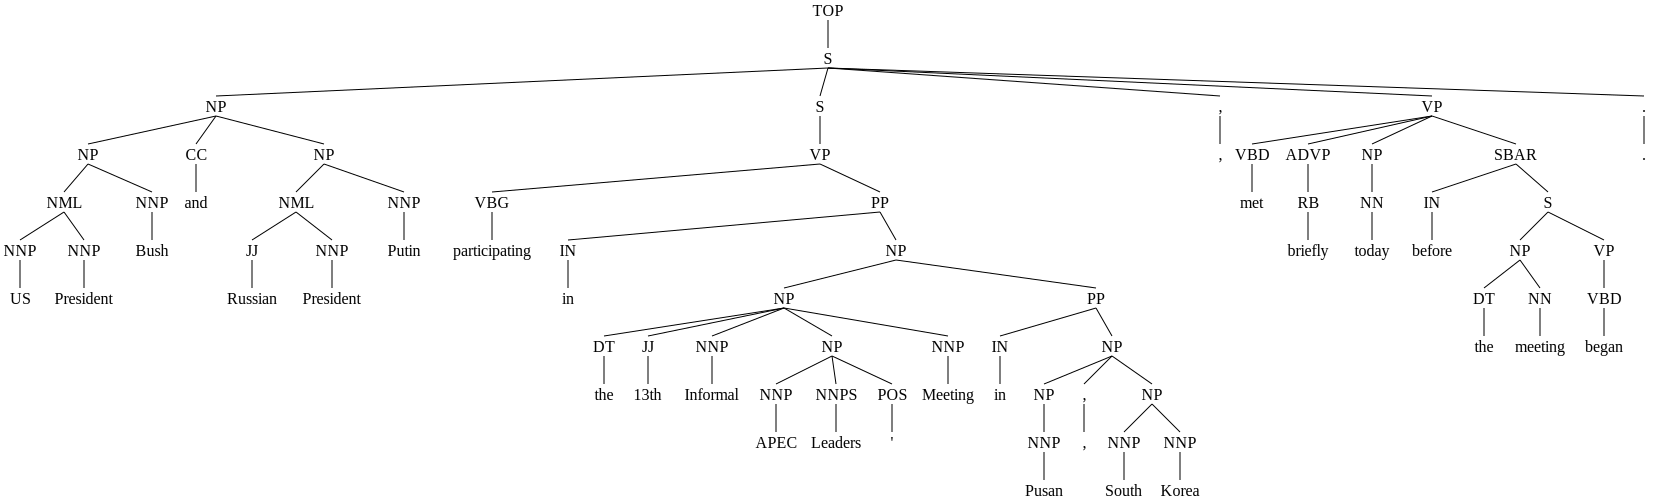

In [97]:
for i, sent in enumerate(ontn_sentc_tree_prc19):
    substr = '(POS \')'
    if substr in sent['parse_tree']:
        display(Tree.fromstring(sent['parse_tree']))
        break

### Delete rare POS

In [98]:
len(ontn_sentc_tree_prc19)

127444

In [99]:
ontn_sentc_tree_prc20 = []
for i, sent in enumerate(ontn_sentc_tree_prc19):
    if not has_substring(sent['parse_tree'], del_pos):
        ontn_sentc_tree_prc20.append(sent)

In [100]:
len(ontn_sentc_tree_prc20)

127430

### Extract rare RP

In [101]:
rp_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc20):
    substr = "(RP"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in rp_nt.keys():
                rp_nt[extraction] += 1
            else:
                rp_nt[extraction] = 1
rp_nt = pd.Series(rp_nt, name='N').to_frame()
rp_nt = rp_nt.sort_values('N', ascending=False)
display(rp_nt.T)
del_rp = rp_nt[rp_nt['N'] <= 1].index.to_list()
print(del_rp)

,(RP up),(RP out),(RP down),(RP off),(RP on),(RP in),(RP over),(RP back),(RP away),(RP around),(RP through),(RP about),(RP along),(RP by),(RP together),(RP forward),(RP forth),(RP aside),(RP for),(RP across),(RP Up),(RP with),(RP behind),(RP open),(RP upon),(RP apart),(RP Out),(RP ahead),(RP UP),(RP Back),(RP of),(RP to),(RP In),(RP On),(RP against),(RP Down),(RP as),(RP Howard),(RP ON),(RP backed),(RP before),(RP even),(RP at),(RP whole),(RP obstacles),(RP a),(RP i-),(RP though),(RP o-),(RP after),(RP unto),(RP Away),(RP Off)
N,3151,2376,895,775,564,547,361,261,139,77,64,54,42,37,34,24,16,13,10,9,9,8,8,6,6,6,6,5,3,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(RP On)', '(RP against)', '(RP Down)', '(RP as)', '(RP Howard)', '(RP ON)', '(RP backed)', '(RP before)', '(RP even)', '(RP at)', '(RP whole)', '(RP obstacles)', '(RP a)', '(RP i-)', '(RP though)', '(RP o-)', '(RP after)', '(RP unto)', '(RP Away)', '(RP Off)']


### Delete rare RP

In [102]:
len(ontn_sentc_tree_prc20)

127430

In [103]:
ontn_sentc_tree_prc21 = []
for i, sent in enumerate(ontn_sentc_tree_prc20):
    if not has_substring(sent['parse_tree'], del_rp):
        ontn_sentc_tree_prc21.append(sent)

In [104]:
len(ontn_sentc_tree_prc21)

127410

### Extract rare WRB

In [105]:
wrb_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc21):
    substr = "(WRB"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in wrb_nt.keys():
                wrb_nt[extraction] += 1
            else:
                wrb_nt[extraction] = 1
wrb_nt = pd.Series(wrb_nt, name='N').to_frame()
wrb_nt = wrb_nt.sort_values('N', ascending=False)
display(wrb_nt.T)
del_wrb = wrb_nt[wrb_nt['N'] <= 1].index.to_list()
print(del_wrb)

,(WRB when),(WRB how),(WRB where),(WRB When),(WRB why),(WRB How),(WRB Why),(WRB Where),(WRB that),(WRB whenever),(WRB wherever),(WRB Whenever),(WRB whereby),(WRB however),(WRB WHEN),(WRB wherein),(WRB However),(WRB WHY),(WRB HOW),(WRB as),(WRB That),(WRB whereupon),(WRB WHERE),(WRB long),(WRB Wherein),(WRB Everywhere),(WRB *when*)
N,3270,1564,1400,1249,674,388,352,112,62,45,41,19,8,7,5,4,3,3,1,1,1,1,1,1,1,1,1


['(WRB HOW)', '(WRB as)', '(WRB That)', '(WRB whereupon)', '(WRB WHERE)', '(WRB long)', '(WRB Wherein)', '(WRB Everywhere)', '(WRB *when*)']


### Delete rare WRB

In [106]:
len(ontn_sentc_tree_prc21)

127410

In [107]:
ontn_sentc_tree_prc22 = []
for i, sent in enumerate(ontn_sentc_tree_prc21):
    if not has_substring(sent['parse_tree'], del_wrb):
        ontn_sentc_tree_prc22.append(sent)

In [108]:
len(ontn_sentc_tree_prc22)

127401

### Extract rare UH

In [109]:
uh_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc22):
    substr = "(UH"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '%']) or len(extraction) > 10:
                if extraction in uh_nt.keys():
                    uh_nt[extraction] += 1
                else:
                    uh_nt[extraction] = 1
uh_nt = pd.Series(uh_nt, name='N').to_frame()
uh_nt = uh_nt.sort_values('N', ascending=False)
display(uh_nt.T)
del_uh = uh_nt[uh_nt['N'] <= 10].index.to_list()
print(del_uh)

,(UH %um),(UH %uh),(UH Uh-huh),(UH uh-huh),(UH please),(UH Please),(UH %eh),(UH %mm),(UH %hm),(UH %huh),(UH %ah),(UH anyway),(UH Anyway),(UH Alright),(UH goodness),(UH Welcome),(UH alright),(UH Anyhow),(UH good-bye),(UH fucking),(UH Indeed),(UH Good-bye),(UH goodbye),(UH Excellent),(UH Anyways),(UH Fucking),(UH attention),(UH Goodbye),(UH Whoopee),(UH zounds),(UH shucks),(UH farewell),(UH stroke),(UH unquote),(UH gr-r-r),(UH welcome),(UH %er),(UH **Eee**.),(UH **Yuh**),(UH bloody),(UH **luch**),(UH anyhow),(UH brother),(UH %ach),(UH %ha),(UH anyways),(UH frigging),(UH Aaaaahhh),(UH Braawwk),(UH Braawwkkk),(UH D'oh!),(UH Shalom),(UH Christ),(UH Abather),(UH thanks),(UH yeeesh),(UH hehehe),(UH Pardon),(UH Hallelujah),(UH Goodness)
N,696,631,498,376,117,110,107,106,89,82,67,46,29,26,13,9,8,6,6,5,4,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(UH Welcome)', '(UH alright)', '(UH Anyhow)', '(UH good-bye)', '(UH fucking)', '(UH Indeed)', '(UH Good-bye)', '(UH goodbye)', '(UH Excellent)', '(UH Anyways)', '(UH Fucking)', '(UH attention)', '(UH Goodbye)', '(UH Whoopee)', '(UH zounds)', '(UH shucks)', '(UH farewell)', '(UH stroke)', '(UH unquote)', '(UH gr-r-r)', '(UH welcome)', '(UH %er)', '(UH **Eee**.)', '(UH **Yuh**)', '(UH bloody)', '(UH **luch**)', '(UH anyhow)', '(UH brother)', '(UH %ach)', '(UH %ha)', '(UH anyways)', '(UH frigging)', '(UH Aaaaahhh)', '(UH Braawwk)', '(UH Braawwkkk)', "(UH D'oh!)", '(UH Shalom)', '(UH Christ)', '(UH Abather)', '(UH thanks)', '(UH yeeesh)', '(UH hehehe)', '(UH Pardon)', '(UH Hallelujah)', '(UH Goodness)']


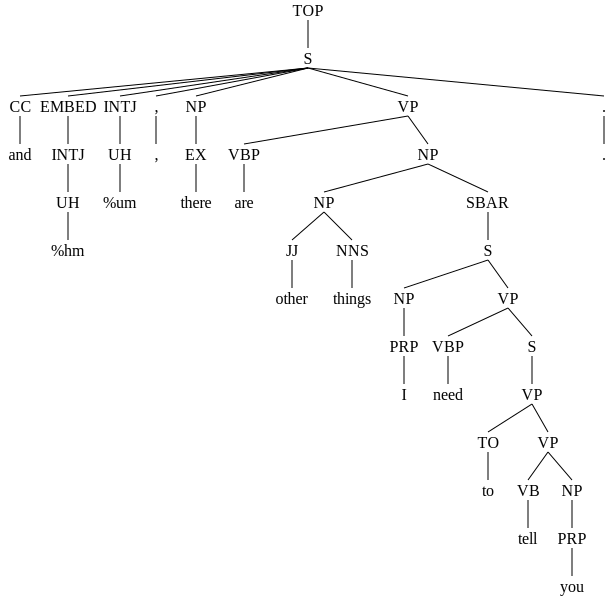

In [110]:
for i, sent in enumerate(ontn_sentc_tree_prc22):
    substr = '(UH %hm)'
    if substr in sent['parse_tree']:
        display(Tree.fromstring(sent['parse_tree']))
        break

### Delete rare UH

In [111]:
len(ontn_sentc_tree_prc22)

127401

In [112]:
ontn_sentc_tree_prc23 = []
for i, sent in enumerate(ontn_sentc_tree_prc22):
    if not has_substring(sent['parse_tree'], del_uh):
        ontn_sentc_tree_prc23.append(sent)

In [113]:
len(ontn_sentc_tree_prc23)

127316

### Extract rare MD

In [114]:
md_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc23):
    substr = "(MD"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in md_nt.keys():
                md_nt[extraction] += 1
            else:
                md_nt[extraction] = 1
md_nt = pd.Series(md_nt, name='N').to_frame()
md_nt = md_nt.sort_values('N', ascending=False)
display(md_nt.T)
del_md = md_nt[md_nt['N'] <= 4].index.to_list()
print(del_md)

,(MD will),(MD would),(MD can),(MD could),(MD should),(MD may),(MD must),(MD 'll),(MD might),(MD ca),(MD wo),(MD 'd),(MD ought),(MD Can),(MD Will),(MD May),(MD shall),(MD Should),(MD Would),(MD Could),(MD need),(MD Ca),(MD Must),(MD Might),(MD Wo),(MD WILL),(MD 'ma),(MD dare),(MD range),(MD just),(MD Do),(MD most),(MD mighta),(MD SHOULD),(MD me-),(MD Let),(MD w-),(MD c),(MD MUST),(MD COULD),(MD wll),(MD and),(MD wo-),(MD mus)
N,9702,4831,4074,2635,2056,1478,1184,905,800,619,475,366,100,99,83,69,54,48,48,34,19,15,5,4,4,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(MD Might)', '(MD Wo)', '(MD WILL)', "(MD 'ma)", '(MD dare)', '(MD range)', '(MD just)', '(MD Do)', '(MD most)', '(MD mighta)', '(MD SHOULD)', '(MD me-)', '(MD Let)', '(MD w-)', '(MD c)', '(MD MUST)', '(MD COULD)', '(MD wll)', '(MD and)', '(MD wo-)', '(MD mus)']


### Delete rare MD

In [115]:
len(ontn_sentc_tree_prc23)

127316

In [116]:
ontn_sentc_tree_prc24 = []
for i, sent in enumerate(ontn_sentc_tree_prc23):
    if not has_substring(sent['parse_tree'], del_md):
        ontn_sentc_tree_prc24.append(sent)

In [117]:
len(ontn_sentc_tree_prc24)

127287

### Extract rare RBR

In [118]:
rbr_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc24):
    substr = "(RBR "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in rbr_nt.keys():
                rbr_nt[extraction] += 1
            else:
                rbr_nt[extraction] = 1
rbr_nt = pd.Series(rbr_nt, name='N').to_frame()
rbr_nt = rbr_nt.sort_values('N', ascending=False)
display(rbr_nt.T)
del_rbr = rbr_nt[rbr_nt['N'] <= 2].index.to_list()
print(del_rbr)

,(RBR more),(RBR earlier),(RBR less),(RBR longer),(RBR better),(RBR later),(RBR further),(RBR Earlier),(RBR Later),(RBR higher),(RBR lower),(RBR faster),(RBR closer),(RBR More),(RBR harder),(RBR sooner),(RBR farther),(RBR louder),(RBR worse),(RBR easier),(RBR wider),(RBR quicker),(RBR cleaner),(RBR deeper),(RBR stronger),(RBR Worse),(RBR Less),(RBR kind),(RBR nicer),(RBR nearer),(RBR Closer),(RBR never),(RBR smarter),(RBR Better),(RBR slower),(RBR brighter),(RBR lighter),(RBR gloomier),(RBR best),(RBR about),(RBR straighter),(RBR cheaper),(RBR heavier),(RBR longest),(RBR little),(RBR In),(RBR fewer),(RBR poorer),(RBR rosier),(RBR than),(RBR aka),(RBR truer),(RBR softer),(RBR drearier),(RBR hardest),(RBR greener)
N,1653,376,276,149,139,97,75,60,60,55,54,48,48,45,28,22,14,10,10,6,5,4,4,4,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(RBR kind)', '(RBR nicer)', '(RBR nearer)', '(RBR Closer)', '(RBR never)', '(RBR smarter)', '(RBR Better)', '(RBR slower)', '(RBR brighter)', '(RBR lighter)', '(RBR gloomier)', '(RBR best)', '(RBR about)', '(RBR straighter)', '(RBR cheaper)', '(RBR heavier)', '(RBR longest)', '(RBR little)', '(RBR In)', '(RBR fewer)', '(RBR poorer)', '(RBR rosier)', '(RBR than)', '(RBR aka)', '(RBR truer)', '(RBR softer)', '(RBR drearier)', '(RBR hardest)', '(RBR greener)']


### Delete rare RBR

In [119]:
len(ontn_sentc_tree_prc24)

127287

In [120]:
ontn_sentc_tree_prc25 = []
for i, sent in enumerate(ontn_sentc_tree_prc24):
    if not has_substring(sent['parse_tree'], del_rbr):
        ontn_sentc_tree_prc25.append(sent)

In [121]:
len(ontn_sentc_tree_prc25)

127250

### Extract rare RBS

In [122]:
rbs_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc25):
    substr = "(RBS "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in rbs_nt.keys():
                rbs_nt[extraction] += 1
            else:
                rbs_nt[extraction] = 1
rbs_nt = pd.Series(rbs_nt, name='N').to_frame()
rbs_nt = rbs_nt.sort_values('N', ascending=False)
display(rbs_nt.T)
del_rbs = ['(RBS Next)', '(RBS last)', '(RBS less)']
print(del_rbs)

,(RBS most),(RBS least),(RBS best),(RBS Most),(RBS hardest),(RBS fastest),(RBS highest),(RBS worst),(RBS longest),(RBS lowest),(RBS less),(RBS Worst),(RBS shortest),(RBS Best),(RBS Hardest),(RBS earliest),(RBS youngest),(RBS Next),(RBS latest),(RBS brightest),(RBS farthest),(RBS last),(RBS biggest)
N,951,219,65,43,13,13,12,6,5,4,3,2,1,1,1,1,1,1,1,1,1,1,1


['(RBS Next)', '(RBS last)', '(RBS less)']


### Delete rare RBS

In [123]:
len(ontn_sentc_tree_prc25)

127250

In [124]:
ontn_sentc_tree_prc26 = []
for i, sent in enumerate(ontn_sentc_tree_prc25):
    if not has_substring(sent['parse_tree'], del_rbs):
        ontn_sentc_tree_prc26.append(sent)

In [125]:
len(ontn_sentc_tree_prc26)

127245

### Extract rare JJ

In [126]:
jj_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc26):
    substr = "(JJ"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '-)', '\')', '&']):
                if extraction in jj_nt.keys():
                    jj_nt[extraction] += 1
                else:
                    jj_nt[extraction] = 1
jj_nt = pd.Series(jj_nt, name='N').to_frame()
jj_nt = jj_nt.sort_values('N', ascending=False)
display(jj_nt.T)
del_jj = jj_nt.index.to_list()
print(del_jj)

,(JJ -),(JJ **staticky**),(JJ su-),(JJ **icky**),(JJ falutin'),(JJ +hierarchial),(JJ ado-),(JJ f-),(JJ small-),(JJ cra-),(JJ beauti-),(JJ bi-),(JJ g-),(JJ be-),(JJ gla-),(JJ ner-),(JJ **cooky**),(JJ **touristy**),(JJ unbe-),(JJ terrib-),(JJ depre-),(JJ enou-),(JJ **pep**),(JJ effect-),(JJ li-),(JJ mu-),(JJ wonderf-),(JJ =just),(JJ friggin'),(JJ +an),(JJ ol'),(JJS bigges-),(JJ Fre-),(JJ =top),(JJ f*cking),(JJ +substantive),(JJ =great),(JJ *cheesy*)
N,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(JJ -)', '(JJ **staticky**)', '(JJ su-)', '(JJ **icky**)', "(JJ falutin')", '(JJ +hierarchial)', '(JJ ado-)', '(JJ f-)', '(JJ small-)', '(JJ cra-)', '(JJ beauti-)', '(JJ bi-)', '(JJ g-)', '(JJ be-)', '(JJ gla-)', '(JJ ner-)', '(JJ **cooky**)', '(JJ **touristy**)', '(JJ unbe-)', '(JJ terrib-)', '(JJ depre-)', '(JJ enou-)', '(JJ **pep**)', '(JJ effect-)', '(JJ li-)', '(JJ mu-)', '(JJ wonderf-)', '(JJ =just)', "(JJ friggin')", '(JJ +an)', "(JJ ol')", '(JJS bigges-)', '(JJ Fre-)', '(JJ =top)', '(JJ f*cking)', '(JJ +substantive)', '(JJ =great)', '(JJ *cheesy*)']


### Delete rare JJ

In [127]:
len(ontn_sentc_tree_prc26)

127245

In [128]:
ontn_sentc_tree_prc27 = []
for i, sent in enumerate(ontn_sentc_tree_prc26):
    if not has_substring(sent['parse_tree'], del_jj):
        ontn_sentc_tree_prc27.append(sent)

In [129]:
len(ontn_sentc_tree_prc27)

127204

### Extract rare RB

In [130]:
rb_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc27):
    substr = "(RB "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            # if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '-)', '\')', '&']):
            if extraction in rb_nt.keys():
                rb_nt[extraction] += 1
            else:
                rb_nt[extraction] = 1
rb_nt = pd.Series(rb_nt, name='N').to_frame()
rb_nt = rb_nt.sort_values('N', ascending=False)
display(rb_nt.T)

,(RB not),(RB n't),(RB also),(RB so),(RB just),(RB now),(RB very),(RB So),(RB only),(RB then),(RB even),(RB still),(RB Then),(RB there),(RB as),(RB here),(RB back),(RB really),(RB well),(RB too),(RB about),(RB never),(RB again),(RB already),(RB away),(RB much),(RB all),(RB ago),(RB always),(RB far),(RB up),(RB together),(RB Now),(RB down),(RB actually),(RB right),(RB ever),(RB first),(RB long),(RB often),(RB recently),(RB However),(RB almost),(RB yet),(RB out),(RB once),(RB probably),(RB home),(RB soon),(RB later),(RB at),(RB especially),(RB currently),(RB rather),(RB in),(RB nearly),(RB of),(RB however),(RB Even),(RB else),(RB quickly),(RB no),(RB Here),(RB over),(RB around),(RB simply),(RB before),(RB ahead),(RB on),(RB certainly),(RB quite),(RB Also),(RB instead),(RB clearly),(RB enough),(RB particularly),(RB maybe),(RB completely),(RB fully),(RB pretty),(RB directly),(RB hard),(RB that),(RB perhaps),(RB immediately),(RB kind),(RB sometimes),(RB early),(RB usually),(RB Meanwhile),(RB extremely),(RB finally),(RB exactly),(RB relatively),(RB further),(RB apparently),(RB abroad),(RB alone),(RB previously),(RB Not),(RB generally),(RB Just),(RB closely),(RB forward),(RB highly),(RB slightly),(RB basically),(RB course),(RB forever),(RB is),(RB Only),(RB though),(RB indeed),(RB mainly),(RB Moreover),(RB increasingly),(RB Still),(RB off),(RB mostly),(RB totally),(RB easily),(RB Instead),(RB Of),(RB largely),(RB late),(RB As),(RB either),(RB eventually),(RB Maybe),(RB rapidly),(RB First),(RB sharply),(RB widely),(RB sort),(RB Currently),(RB seriously),(RB definitely),(RB jointly),(RB gradually),(RB everywhere),(RB overseas),(RB greatly),(RB close),(RB Thus),(RB thus),(RB virtually),(RB actively),(RB absolutely),(RB Indeed),(RB publicly),(RB obviously),(RB fairly),(RB therefore),(RB strongly),(RB surely),(RB Therefore),(RB suddenly),(RB twice),(RB next),(RB behind),(RB apart),(RB possibly),(RB after),(RB longer),(RB Perhaps),(RB respectively),(RB effectively),(RB heavily),(RB normally),(RB typically),(RB partly),(RB deeply),(RB high),(RB carefully),(RB significantly),(RB fast),(RB originally),(RB somewhat),(RB truly),(RB anymore),(RB There),(RB frequently),(RB primarily),(RB badly),(RB elsewhere),(RB necessarily),(RB specifically),(RB outside),(RB Finally),(RB merely),(RB newly),(RB little),(RB annually),(RB constantly),(RB officially),(RB inside),(RB somewhere),(RB entirely),(RB ultimately),(RB repeatedly),(RB matter),(RB otherwise),(RB hardly),(RB anywhere),(RB Recently),(RB along),(RB personally),(RB naturally),(RB successively),(RB successfully),(RB properly),(RB All),(RB anyway),(RB About),(RB likely),(RB Yet),(RB initially),(RB by),(RB Actually),(RB forth),(RB temporarily),(RB aside),(RB Once),(RB second),(RB above),(RB substantially),(RB formerly),(RB privately),(RB meanwhile),(RB Nevertheless),(RB Later),(RB Unfortunately),(RB formally),(RB barely),(RB continuously),(RB roughly),(RB prior),(RB approximately),(RB slowly),(RB south),(RB wide),(RB steadily),(RB better),(RB Rather),(RB That),(RB allegedly),(RB daily),(RB openly),(RB quietly),(RB because),...,(RB same),(RB hoplessly),(RB intently),(RB elderly),(RB faily),(RB Objectively),(RB disingenuously),(RB dispassionately),(RB prevously),(RB exact),(RB profusely),(RB conventionally),(RB intuitively),(RB avowedly),(RB charitably),(RB metaphorically),(RB inescapably),(RB multilaterally),(RB Militarily),(RB rights),(RB behaviorally),(RB signally),(RB Seriously),(RB secondarily),(RB closey),(RB willinging),(RB stylishly),(RB occupationally),(RB abjectly),(RB graphically),(RB maddeningly),(RB manifestly),(RB evend),(RB dauntlessly),(RB obligingly),(RB negligently),(RB compactly),(RB sheepishly),(RB unwittingly),(RB playfully),(RB heroically),(RB incendiarially),(RB twofold),(RB faraway),(RB funny),(RB pathetically),(RB imploringly),(RB Half),(RB Reportedly),(RB unfathomably),(RB co-operatively),(RB speechlessly),(RB acutually),(RB diametrically),(RB Economically),(RB threefold),(R

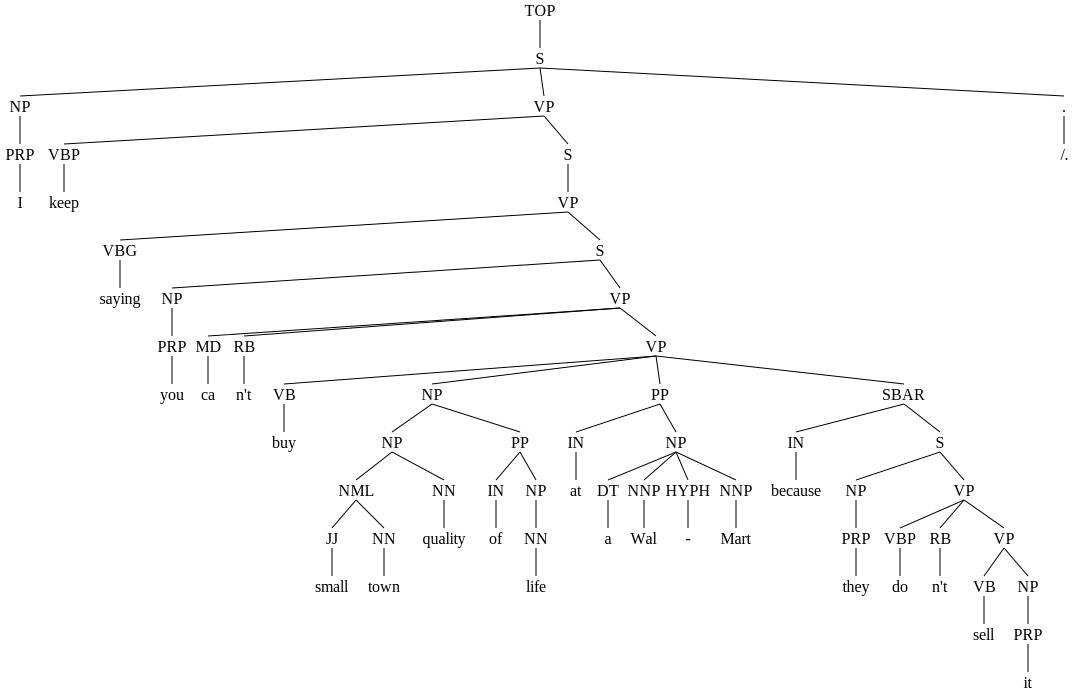

In [131]:
for i, sent in enumerate(ontn_sentc_tree_prc27):
    substr = '(MD ca)'
    if substr in sent['parse_tree']:
        display(Tree.fromstring(sent['parse_tree']))
        break

In [132]:
symrb_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc27):
    substr = "(RB "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '-)', '\')', '&']):
                if extraction in symrb_nt.keys():
                    symrb_nt[extraction] += 1
                else:
                    symrb_nt[extraction] = 1
symrb_nt = pd.Series(symrb_nt, name='N').to_frame()
symrb_nt = symrb_nt.sort_values('N', ascending=False)
display(symrb_nt.T)
del_rb = symrb_nt.index.to_list()
print(del_rb)

,(RB j-),(RB =particularly),(RB jus-),(RB Real-),(RB ext-),(RB +invariably),(RB the-),(RB kin-),(RB twi-),(RB relat-),(RB nex-),(RB may-),(RB su-),(RB basic-),(RB re-),(RB +really),(RB a-),(RB =bitterly),(RB he-),(RB th-),(RB +already),(RB *extremely*)
N,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(RB j-)', '(RB =particularly)', '(RB jus-)', '(RB Real-)', '(RB ext-)', '(RB +invariably)', '(RB the-)', '(RB kin-)', '(RB twi-)', '(RB relat-)', '(RB nex-)', '(RB may-)', '(RB su-)', '(RB basic-)', '(RB re-)', '(RB +really)', '(RB a-)', '(RB =bitterly)', '(RB he-)', '(RB th-)', '(RB +already)', '(RB *extremely*)']


### Delete rare RB

In [133]:
len(ontn_sentc_tree_prc27)

127204

In [134]:
ontn_sentc_tree_prc28 = []
for i, sent in enumerate(ontn_sentc_tree_prc27):
    if not has_substring(sent['parse_tree'], del_rb):
        ontn_sentc_tree_prc28.append(sent)

In [135]:
len(ontn_sentc_tree_prc28)

127181

### Extract rare TO and IN

In [136]:
to_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc28):
    substr = "(TO "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            # if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '-)', '\')', '&']):
            if extraction in to_nt.keys():
                to_nt[extraction] += 1
            else:
                to_nt[extraction] = 1
to_nt = pd.Series(to_nt, name='N').to_frame()
rb_to_ntnt = to_nt.sort_values('N', ascending=False)
display(to_nt.T)
del_to = to_nt[to_nt['N'] <= 8].index.to_list()
print(del_to)

,(TO to),(TO To),(TO na),(TO TO),(TO a),(TO t-),(TO -),(TO ta),(TO too),(TO do)
N,35848,270,8,3,1,1,1,2,1,1


['(TO na)', '(TO TO)', '(TO a)', '(TO t-)', '(TO -)', '(TO ta)', '(TO too)', '(TO do)']


In [137]:
in_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc28):
    substr = "(IN "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            # if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '-)', '\')', '&']):
            if extraction in in_nt.keys():
                in_nt[extraction] += 1
            else:
                in_nt[extraction] = 1
in_nt = pd.Series(in_nt, name='N').to_frame()
in_nt = in_nt.sort_values('N', ascending=False)
display(in_nt.T)
del_in = in_nt[in_nt['N'] <= 8].index.to_list()
print(del_in)

,(IN of),(IN in),(IN to),(IN for),(IN that),(IN with),(IN on),(IN from),(IN by),(IN as),(IN at),(IN about),(IN In),(IN than),(IN because),(IN if),(IN into),(IN like),(IN after),(IN over),(IN If),(IN against),(IN before),(IN through),(IN between),(IN under),(IN out),(IN while),(IN since),(IN At),(IN during),(IN For),(IN As),(IN so),(IN among),(IN without),(IN until),(IN After),(IN around),(IN whether),(IN On),(IN With),(IN within),(IN While),(IN up),(IN though),(IN Because),(IN near),(IN By),(IN toward),(IN across),(IN along),(IN off),(IN behind),(IN Although),(IN Since),(IN per),(IN although),(IN above),(IN From),(IN During),(IN down),(IN outside),(IN inside),(IN Under),(IN despite),(IN below),(IN upon),(IN Among),(IN via),(IN towards),(IN except),(IN beyond),(IN throughout),(IN unless),(IN once),(IN Before),(IN Despite),(IN onto),(IN To),(IN but),(IN Of),(IN Though),(IN ago),(IN Like),(IN Over),(IN due),(IN next),(IN amid),(IN So),(IN Until),(IN Without),(IN That),(IN past),(IN Once),(IN Whether),(IN Besides),(IN Within),(IN Through),(IN unlike),(IN Unlike),(IN till),(IN beside),(IN About),(IN aboard),(IN whereas),(IN Unless),(IN Up),(IN beneath),(IN vs.),(IN besides),(IN Amid),(IN Along),(IN cause),(IN Between),(IN OF),(IN amongst),(IN alongside),(IN Due),(IN Beyond),(IN Out),(IN Upon),(IN versus),(IN Whereas),(IN Inside),(IN Throughout),(IN de),(IN Across),(IN Around),(IN Behind),(IN Except),(IN Per),(IN Against),(IN Above),(IN whilst),(IN then),(IN notwithstanding),(IN instead),(IN albeit),(IN Outside),(IN amidst),(IN underneath),(IN Off),(IN IF),(IN IN),(IN plus),(IN unto),(IN lest),(IN Near),(IN According),(IN atop),(IN opposite),(IN v.),(IN worth),(IN Amidst),(IN rather),(IN Re),(IN thru),(IN en),(IN round),(IN FOR),(IN TO),(IN Alongside),(IN wo),(IN and),(IN v),(IN cuz),(IN a),(IN according),(IN astride),(IN onboard),(IN Than),(IN such),(IN &of),(IN minus),(IN Towards),(IN agaisnt),(IN which),(IN be),(IN apart),(IN Down),(IN AS),(IN Next),(IN WITHOUT),(IN prior),(IN Into),(IN But),(IN including),(IN Instead),(IN verses),(IN save),(IN Beside),(IN DESPITE),(IN nearby),(IN Zhou),(IN ahold),(IN En),(IN w),(IN OVER),(IN cross),(IN 'cause),(IN threw),(IN a.k.a.),(IN Underneath),(IN 'bout),(IN +between),(IN far),(IN par),(IN becase),(IN 'til),(IN pending),(IN Toward),(IN UNDER),(IN yet),(IN overseas),(IN whence),(IN liked),(IN gainst),(IN aside),(IN producer),(IN Beneath),(IN nearer),(IN fiscal),(IN THAN),(IN Atop),(IN nearest),(IN expect),(IN whereby),(IN furnace),(IN Concerning),(IN inasmuch),(IN Notwithstanding),(IN WITH),(IN AMONG),(IN THROUGHOUT),(IN Till),(IN Neither),(IN &on),(IN &to),(IN only),(IN all),(IN soon),(IN Regarding),(IN Apart),(IN when),(IN &in),(IN ab-),(IN af-),(IN vis-à-vis),(IN +under),(IN ovre),(IN befo-),(IN Cause),(IN fo),(IN or),(IN re),(IN vs),(IN gross),(IN too),(IN belong),(IN 'Cause),(IN following),(IN insofar),(IN tho),(IN embroil),(IN assets),(IN foreign),(IN l-),(IN mom)
N,56660,35592,22148,17567,13753,12230,11991,9526,8328,8149,7986,4349,3496,3373,3145,2810,2776,2314,2213,1893,1564,1468,1417,1407,1361,1101,1014,999,987,891,888,834,828,778,736,727,717,669,643,594,579,426,399,392,383,350,324,320,298,296,289,278,273,261,256,254,225,213,210,204,203,203,192,175,172,170,165,159,155,147,141,138,137,136,122,118,117,115,107,105,104,92,89,86,84,82,80,76,74,67,57,56,52,51,49,46,44,44,44,43,43,41,41,34,32,30,29,28,26,24,23,21,20,20,20,19,17,16,16,16,16,15,15,14,14,13,13,13,12,12,11,11,10,10,8,8,8,7,7,7,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(IN whilst)', '(IN then)', '(IN notwithstanding)', '(IN instead)', '(IN albeit)', '(IN Outside)', '(IN amidst)', '(IN underneath)', '(IN Off)', '(IN IF)', '(IN IN)', '(IN plus)', '(IN unto)', '(IN lest)', '(IN Near)', '(IN According)', '(IN atop)', '(IN opposite)', '(IN v.)', '(IN worth)', '(IN Amidst)', '(IN rather)', '(IN Re)', '(IN thru)', '(IN en)', '(IN round)', '(IN FOR)', '(IN TO)', '(IN Alongside)', '(IN wo)', '(IN and)', '(IN v)', '(IN cuz)', '(IN a)', '(IN according)', '(IN astride)', '(IN onboard)', '(IN Than)', '(IN such)', '(IN &of)', '(IN minus)', '(IN Towards)', '(IN agaisnt)', '(IN which)', '(IN be)', '(IN apart)', '(IN Down)', '(IN AS)', '(IN Next)', '(IN WITHOUT)', '(IN prior)', '(IN Into)', '(IN But)', '(IN including)', '(IN Instead)', '(IN verses)', '(IN save)', '(IN Beside)', '(IN DESPITE)', '(IN nearby)', '(IN Zhou)', '(IN ahold)', '(IN En)', '(IN w)', '(IN OVER)', '(IN cross)', "(IN 'cause)", '(IN threw)', '(IN a.k.a.)', '(IN Underneath)', "(IN 'bout)", '(IN +b

In [138]:
del_to_in = del_to + del_in

### Delete rare TO and IN

In [139]:
len(ontn_sentc_tree_prc28)

127181

In [140]:
ontn_sentc_tree_prc29 = []
for i, sent in enumerate(ontn_sentc_tree_prc28):
    if not has_substring(sent['parse_tree'], del_to_in):
        ontn_sentc_tree_prc29.append(sent)

In [141]:
len(ontn_sentc_tree_prc29)

126844

### Top cases which started with period

In [142]:
available_top_prods

['TOP -> S',
 'TOP -> INTJ',
 'TOP -> FRAG',
 'TOP -> NP',
 'TOP -> SINV',
 'TOP -> SBARQ',
 'TOP -> SQ',
 'TOP -> SBAR']

In [143]:
def _add_to_nt(substr, parse_tree, _nt):
    if substr in parse_tree:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in _nt.keys():
                _nt[extraction] += 1
            else:
                _nt[extraction] = 1

nt = {}
for i, sent in enumerate(ontn_sentc_tree_prc29):
    _add_to_nt("(S (.", sent['parse_tree'], nt)
    _add_to_nt("(S (,", sent['parse_tree'], nt)
    _add_to_nt("(INTJ (.", sent['parse_tree'], nt)
    _add_to_nt("(INTJ (,", sent['parse_tree'], nt)
    _add_to_nt("(NP (.", sent['parse_tree'], nt)
    _add_to_nt("(NP (,", sent['parse_tree'], nt)
    _add_to_nt("(SINV (.", sent['parse_tree'], nt)
    _add_to_nt("(SINV (,", sent['parse_tree'], nt)
    _add_to_nt("(SBARQ (.", sent['parse_tree'], nt)
    _add_to_nt("(SBARQ (,", sent['parse_tree'], nt)
    _add_to_nt("(SQ (.", sent['parse_tree'], nt)
    _add_to_nt("(SQ (,", sent['parse_tree'], nt)
    _add_to_nt("(SBAR (.", sent['parse_tree'], nt)
    _add_to_nt("(SBAR (,", sent['parse_tree'], nt)
    _add_to_nt("(S(.", sent['parse_tree'], nt)
    _add_to_nt("(S(,", sent['parse_tree'], nt)
    _add_to_nt("(INTJ(.", sent['parse_tree'], nt)
    _add_to_nt("(INTJ(,", sent['parse_tree'], nt)
    _add_to_nt("(NP(.", sent['parse_tree'], nt)
    _add_to_nt("(NP(,", sent['parse_tree'], nt)
    _add_to_nt("(SINV(.", sent['parse_tree'], nt)
    _add_to_nt("(SINV(,", sent['parse_tree'], nt)
    _add_to_nt("(SBARQ(.", sent['parse_tree'], nt)
    _add_to_nt("(SBARQ(,", sent['parse_tree'], nt)
    _add_to_nt("(SQ(.", sent['parse_tree'], nt)
    _add_to_nt("(SQ(,", sent['parse_tree'], nt)
    _add_to_nt("(SBAR(.", sent['parse_tree'], nt)
    _add_to_nt("(SBAR(,", sent['parse_tree'], nt)
    _add_to_nt("(TOP (.", sent['parse_tree'], nt)
    _add_to_nt("(TOP (,", sent['parse_tree'], nt)
nt = pd.Series(nt, name='N').to_frame()
nt = nt.sort_values('N', ascending=False)
display(nt.T)
del_nt = nt.index.to_list()
print(del_nt)

,"(S (, ,)","(NP (, ,)","(SBAR (, ,)","(INTJ (, ,)","(SBARQ (, ,)",(INTJ (. .),"(SQ (, ,)",(NP (. /.),(S (. .),"(SINV (, ,)"
N,152,66,34,4,3,2,2,1,1,1


['(S (, ,)', '(NP (, ,)', '(SBAR (, ,)', '(INTJ (, ,)', '(SBARQ (, ,)', '(INTJ (. .)', '(SQ (, ,)', '(NP (. /.)', '(S (. .)', '(SINV (, ,)']


### Delete rare NT

In [144]:
len(ontn_sentc_tree_prc29)

126844

In [145]:
ontn_sentc_tree_prc30 = []
for i, sent in enumerate(ontn_sentc_tree_prc29):
    if not has_substring(sent['parse_tree'], del_nt):
        ontn_sentc_tree_prc30.append(sent)

In [146]:
len(ontn_sentc_tree_prc30)

126580

### Extract rare WP

In [147]:
wp_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc30):
    substr = "(WP "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            # if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`', '+', '=', '*', '^', '-)', '\')', '&']):
            if extraction in wp_nt.keys():
                wp_nt[extraction] += 1
            else:
                wp_nt[extraction] = 1
wp_nt = pd.Series(wp_nt, name='N').to_frame()
wp_nt = wp_nt.sort_values('N', ascending=False)
display(wp_nt.T)
del_wp = wp_nt[wp_nt['N'] <= 6].index.to_list()
print(del_wp)

,(WP who),(WP what),(WP What),(WP Who),(WP whom),(WP Whoever),(WP whoever),(WP whatever),(WP WHO),(WP that),(WP Whatever),(WP wha-),(WP wh-)
N,6111,4056,905,178,117,92,59,31,6,3,3,1,1


['(WP WHO)', '(WP that)', '(WP Whatever)', '(WP wha-)', '(WP wh-)']


### Delete rare WP

In [148]:
len(ontn_sentc_tree_prc30)

126580

In [149]:
ontn_sentc_tree_prc31 = []
for i, sent in enumerate(ontn_sentc_tree_prc30):
    if not has_substring(sent['parse_tree'], del_wp):
        ontn_sentc_tree_prc31.append(sent)

In [150]:
len(ontn_sentc_tree_prc31)

126566

## Replace Nonterminal in Trees

In [151]:
nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc31):
    substr = "(VBG Doing)"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in nt.keys():
                nt[extraction] += 1
            else:
                nt[extraction] = 1
print(nt)

{'(VBG Doing) (SBAR(WHNP (WP what)': 1, '(VBG Doing) (NP (NN business)': 1, '(VBG Doing) (NP (NN wrong)': 1, '(VBG Doing) (NP (DT that)': 1, '(VBG Doing) (NP (DT the)': 1}


In [152]:
replace_dict = {
    '(. ?)': '(QM ?)',  # question mark
    '(. /?)': '(QM ?)',  # question mark
    '(. .)': '(PER .)',  # period
    '(. /.)': '(PER .)',  # period
    '(. !)': '(EM !)',  # exclamation mark
    '(. ...)': '(ELPSS ...)',  # ellipsis
    '(, ,)': '(CMA ,)',  # comma
    '(: :)': '(CLN :)',  # punctuation COLON
    '(: ;)': '(SMCLN ;)',  # punctuation semicolon
    '(: --)': '(DASH --)',  # punctuation dash
    '(: -)': '(HPHN -)',  # punctuation hyphen
    '(: ...)': '(PNCTELPSS ...)',  # punctuation ellipsis
    '(DT a)': '(IAC a)',  # indefinite article before a consonant
    '(DT A)': '(IAC A)',  # indefinite article before a consonant
    '(DT an)': '(IAV an)',  # indefinite article before a vowel
    '(DT An)': '(IAV An)',  # indefinite article before a vowel
    '(DT the)': '(DA the)', # definite article
    '(DT The)': '(DA The)', # definite article
    '(`` ")': '(OQTM ``)',   # Opening quotation marks
    '(`` ``)': '(OQTM ``)',   # Opening quotation marks
    '(`` \')': '(OQTM ``)',   # Opening quotation marks
    '(`` `)': '(OQTM ``)',   # Opening quotation marks
    '(\'\' ")': '(QTM `)',  # Quotation marks
    '(\'\' \'\')': '(QTM `)',  # Quotation marks
    '(\'\' \')': '(QTM `)',  # Quotation marks
    '(\'\' `)': '(QTM `)',  # Quotation marks
    '(POS \')': '(POSS \')',  # plural POS
    '(CC and)': '(AND and)',  # and
    '(CC And)': '(AND And)',  # and
    '(CC AND)': '(AND And)',  # and
    '(CC but)': '(BUT but)',  # but
    '(CC But)': '(BUT But)',  # but
    '(CC &)': '(AMPND &)',  # ampersand
    '(CC or)': '(OR or)',  # or
    '(CC Or)': '(OR Or)',  # or
    '(CC OR)': '(OR Or)',  # or
    '(RBR more)': '(MORE more)',  # more
    '(RBR More)': '(MORE More)',  # more
    '(RBR MORE)': '(MORE More)',  # more
    '(RBR less)': '(LESS less)',  # less
    '(RBR Less)': '(LESS Less)',  # less
    '(RBR LESS)': '(LESS Less)',  # less
    '(RBS most)': '(MOST most)',  # most
    '(RBS Most)': '(MOST Most)',  # most
    '(RBS MOST)': '(MOST Most)',  # most
    '(RBS best)': '(BEST best)',  # best
    '(RBS Best)': '(BEST Best)',  # best
    '(RBS BEST)': '(BEST Best)',  # best
    '(WP who)': '(WP_WHO who)',
    '(WP Who)': '(WP_WHO Who)',
    '(WP what)': '(WP_WHAT what)',
    '(WP What)': '(WP_WHAT What)',
    # '(RB not)': '(RB_NOT not)',  # not
    # '(RB Not)': '(RB_NOT Not)',  # not
    # '(RB NOT)': '(RB_NOT Not)',  # not
    # '(RB n\'t)': '(RB_NOTP n\'t)',  # not part
    # '(RB N\'T)': '(RB_NOTP n\'t)',  # not part
    # '(RB also)': '(RB_ALSO also)',  # also
    # '(RB Also)': '(RB_ALSO Also)',  # also
    # '(RB ALSO)': '(RB_ALSO Also)',  # also
    # '(RB so)': '(RB_SO so)',  # so
    # '(RB So)': '(RB_SO So)',  # so
    # '(RB SO)': '(RB_SO So)',  # so
    # '(RB just)': '(RB_JUST just)',  # just
    # '(RB Just)': '(RB_JUST Just)',  # just
    # '(RB JUST)': '(RB_JUST Just)',  # just
    # '(RB now)': '(RB_NOW now)',  # now
    # '(RB Now)': '(RB_NOW Now)',  # now
    # '(RB NOW)': '(RB_NOW Now)',  # now
    '(-LRB- -LSB-)': '(_lrb_ _lsb_)',
    '(-RRB- -RSB-)': '(_rrb_ _rsb_)',
    '(-LRB- -LRB-)': '(_lrb_ _lrb_)',
    '(-RRB- -RRB-)': '(_rrb_ _rrb_)',
    '(-LRB- -LCB-)': '(_lrb_ _lcb_)',
    '(-RRB- -RCB-)': '(_rrb_ _rcb_)',
    '(PRP$': '(PRP_DLR',
    '(WP$': '(WP_DLR',
    '($':'(DLR',
    '(UH %': '(UH ', 
    # '`': '\'',
}

In [153]:
nt = {}
for i, sent in enumerate(ontn_sentc_tree_prc31):
    _add_to_nt("(MD", sent['parse_tree'], nt)
nt = pd.Series(nt, name='N').to_frame()
nt = nt.sort_values('N', ascending=False)
display(nt.T)

,(MD will),(MD would),(MD can),(MD could),(MD should),(MD may),(MD must),(MD 'll),(MD might),(MD ca),(MD wo),(MD 'd),(MD ought),(MD Can),(MD Will),(MD May),(MD shall),(MD Should),(MD Would),(MD Could),(MD need),(MD Ca),(MD Must)
N,9647,4792,4041,2611,2039,1464,1178,901,798,617,471,362,100,97,83,69,53,46,46,34,19,15,5


In [154]:
replace_vb_aux_dict = {
    '(VBZ is)' : '(VBZ_IS is)', '(VBZ Is)' : '(VBZ_IS Is)',
    '(VBD was)': '(VBD_WAS was)', '(VBD Was)': '(VBD_WAS Was)',
    '(VBP are)': '(VBP_ARE are)', '(VBP Are)': '(VBP_ARE Are)',
    '(VB be)': '(VB_BE be)', '(VB Be)': '(VB_BE Be)',
    '(VBZ has)': '(VBZ_HAS has)', '(VBZ Has)': '(VBZ_HAS Has)',
    '(VBP have)': '(VBP_HAVE have)', '(VBP Have)': '(VBP_HAVE Have)',
    "(VBZ 's)": "(VBZ_S 's)",
    '(VBD were)': '(VBD_WERE were)', '(VBD Were)': '(VBD_WERE Were)',
    '(VBD had)': '(VBD_HAD had)', '(VBD Had)': '(VBD_HAD Had)',
    '(VBN been)': '(VBN_BEEN been)', '(VBN Been)': '(VBN_BEEN Been)',
    '(VBP do)': '(VBP_DO do)', '(VBP Do)': '(VBP_DO Do)',
    '(VB have)': '(VB_HAVE have)', '(VB Have)': '(VB_HAVE Have)',
    '(VBD did)': '(VBD_DID did)', '(VBD Did)': '(VBD_DID Did)',
    '(VB do)': '(VB_DO do)', '(VB Do)': '(VB_DO Do)',
    '(VBG going)': '(VBG_GOING going)', '(VBG Going)': '(VBG_GOING Going)',
    "(VBP 're)": "(VBP_RE 're)",
    '(VBZ does)': '(VBZ does)', '(VBZ Does)': '(VBZ Does)',
    '(VBG being)': '(VBG_BEING being)', '(VBG Being)': '(VBG_BEING Being)',
    "(VBP 'm)": "(VBP_M 'm)",
    '(VBP am)': '(VBP_AM am)', '(VBP Am)': '(VBP_AM Am)',
    "(VBP 've)": "(VBP_VE 've)",
    '(VBG doing)': '(VBG_doing doing)', '(VBG Doing)': '(VBG_doing Doing)',
    '(VBN done)': '(VBN_DONE done)', '(VBN Done)': '(VBN_DONE Done)',
    '(MD will)': '(MD_WILL will)', '(MD Will)': '(MD_WILL Will)',
    '(MD would)': '(MD_WOULD would)', '(MD Would)': '(MD_WOULD Would)',
    '(MD can)': '(MD_CAN can)', '(MD Can)': '(MD_CAN Can)',
    '(MD could)': '(MD_COULD could)', '(MD Could)': '(MD_COULD Could)',
    '(MD should)': '(MD_SHOULD should)', '(MD Should)': '(MD_SHOULD Should)',
    '(MD \'ll)': '(MD_LL \'ll)',
    '(MD ca)': '(MD_CA ca)', '(MD Ca)': '(MD_CA Ca)',
    '(MD wo)': '(MD_WO wo)', '(MD Wo)': '(MD_WO Wo)', 
    "(MD 'd)": "(MD_D 'd)"
}
replace_dict.update(replace_vb_aux_dict)

In [155]:
nt = {}
for i, sent in enumerate(ontn_sentc_tree_prc31):
    _add_to_nt("(PRP ", sent['parse_tree'], nt)
nt = pd.Series(nt, name='N').to_frame()
nt = nt.sort_values('N', ascending=False)
display(nt.T)
# nt.index.to_list()

,(PRP I),(PRP it),(PRP you),(PRP he),(PRP they),(PRP we),(PRP He),(PRP them),(PRP him),(PRP It),(PRP me),(PRP They),(PRP We),(PRP she),(PRP You),(PRP us),(PRP her),(PRP She),(PRP themselves),(PRP himself),(PRP itself),(PRP 's),(PRP one),(PRP myself),(PRP yourself),(PRP i),(PRP ourselves),(PRP herself),(PRP mine),(PRP One),(PRP his),(PRP yourselves),(PRP Me),(PRP yours),(PRP theirs),(PRP oneself)
N,16613,14422,14039,9062,8252,5757,4376,4202,3789,3764,3170,3141,2386,2329,2271,1887,843,775,449,447,354,282,192,173,160,78,78,74,38,28,20,20,17,17,13,12


In [156]:
replace_prp_dict = {
    '(PRP i)': '(PRP_FIRST i)', '(PRP I)': '(PRP_FIRST I)',
    '(PRP it)': '(PRP_THIRD it)', '(PRP It)': '(PRP_THIRD It)',
    '(PRP you)': '(PRP_SECOND you)', '(PRP You)': '(PRP_SECOND You)',
    '(PRP he)': '(PRP_THIRD he)', '(PRP He)': '(PRP_THIRD He)',
    '(PRP she)': '(PRP_THIRD she)', '(PRP She)': '(PRP_THIRD She)',
    '(PRP they)': '(PRP_PLUR they)', '(PRP They)': '(PRP_PLUR They)',
    '(PRP we)': '(PRP_PLUR we)', '(PRP We)': '(PRP_PLUR We)'
}
replace_dict.update(replace_prp_dict)

In [157]:
in_nt = {}
for i, sent in enumerate(ontn_sentc_tree_prc31):
    _add_to_nt("(IN ", sent['parse_tree'], in_nt)
in_nt = pd.Series(in_nt, name='N').to_frame()
in_nt = in_nt.sort_values('N', ascending=False)
display(in_nt.T)

for test_in in in_nt[in_nt['N'] >= 1000].index.to_list():
    left = test_in[4:-1]
    left_l = left.lower()
    left_s = left[0].upper() + left[1:]
    left_u = left.upper()
    new_right = f'IN_{left_u}'

    old_prods = (f'(IN {left_l})', f'(IN {left_s})', f'(IN {left_u})')
    if old_prods[0] not in replace_dict.keys():
        new_prods = (f'({new_right} {left_l})', f'({new_right} {left_s})', f'({new_right} {left_s})')
        in_transform = {old_prods[i]: new_prods[i] for i in range(3)}
        replace_dict.update(in_transform)
        print(in_transform)

,(IN of),(IN in),(IN to),(IN for),(IN that),(IN with),(IN on),(IN from),(IN by),(IN as),(IN at),(IN about),(IN In),(IN than),(IN because),(IN if),(IN into),(IN like),(IN after),(IN over),(IN If),(IN against),(IN before),(IN through),(IN between),(IN under),(IN out),(IN while),(IN since),(IN during),(IN At),(IN For),(IN As),(IN so),(IN among),(IN without),(IN until),(IN After),(IN around),(IN whether),(IN On),(IN With),(IN within),(IN While),(IN up),(IN though),(IN Because),(IN near),(IN By),(IN toward),(IN across),(IN along),(IN off),(IN behind),(IN Since),(IN Although),(IN per),(IN although),(IN above),(IN down),(IN From),(IN During),(IN outside),(IN inside),(IN Under),(IN despite),(IN below),(IN upon),(IN Among),(IN via),(IN towards),(IN beyond),(IN throughout),(IN except),(IN unless),(IN once),(IN Before),(IN Despite),(IN onto),(IN To),(IN but),(IN Though),(IN Of),(IN ago),(IN Like),(IN Over),(IN due),(IN next),(IN amid),(IN So),(IN Until),(IN Without),(IN past),(IN That),(IN Once),(IN Whether),(IN Within),(IN Through),(IN Unlike),(IN Besides),(IN unlike),(IN beside),(IN till),(IN About),(IN aboard),(IN whereas),(IN Unless),(IN Up),(IN beneath),(IN vs.),(IN besides),(IN Amid),(IN Along),(IN cause),(IN Between),(IN OF),(IN amongst),(IN Out),(IN Due),(IN Beyond),(IN alongside),(IN Upon),(IN versus),(IN Whereas),(IN de),(IN Across),(IN Throughout),(IN Inside),(IN Around),(IN Behind),(IN Per),(IN Except),(IN Against),(IN Above)
N,56155,35300,21993,17442,13630,12138,11905,9463,8265,8090,7923,4334,3475,3347,3125,2779,2743,2295,2201,1873,1554,1462,1412,1396,1352,1096,1010,996,981,881,879,829,823,772,730,722,713,667,638,590,576,424,393,390,381,347,320,320,296,296,287,276,273,259,254,254,224,211,208,203,203,200,191,173,169,168,165,155,153,146,138,137,136,136,122,118,116,114,107,105,104,89,88,85,83,82,78,76,74,67,57,56,50,50,49,46,44,44,43,43,43,41,41,34,32,29,28,28,25,24,23,21,20,20,20,19,17,16,16,16,16,15,15,14,13,13,13,13,12,12,11,11,10,10


{'(IN of)': '(IN_OF of)', '(IN Of)': '(IN_OF Of)', '(IN OF)': '(IN_OF Of)'}
{'(IN in)': '(IN_IN in)', '(IN In)': '(IN_IN In)', '(IN IN)': '(IN_IN In)'}
{'(IN to)': '(IN_TO to)', '(IN To)': '(IN_TO To)', '(IN TO)': '(IN_TO To)'}
{'(IN for)': '(IN_FOR for)', '(IN For)': '(IN_FOR For)', '(IN FOR)': '(IN_FOR For)'}
{'(IN that)': '(IN_THAT that)', '(IN That)': '(IN_THAT That)', '(IN THAT)': '(IN_THAT That)'}
{'(IN with)': '(IN_WITH with)', '(IN With)': '(IN_WITH With)', '(IN WITH)': '(IN_WITH With)'}
{'(IN on)': '(IN_ON on)', '(IN On)': '(IN_ON On)', '(IN ON)': '(IN_ON On)'}
{'(IN from)': '(IN_FROM from)', '(IN From)': '(IN_FROM From)', '(IN FROM)': '(IN_FROM From)'}
{'(IN by)': '(IN_BY by)', '(IN By)': '(IN_BY By)', '(IN BY)': '(IN_BY By)'}
{'(IN as)': '(IN_AS as)', '(IN As)': '(IN_AS As)', '(IN AS)': '(IN_AS As)'}
{'(IN at)': '(IN_AT at)', '(IN At)': '(IN_AT At)', '(IN AT)': '(IN_AT At)'}
{'(IN about)': '(IN_ABOUT about)', '(IN About)': '(IN_ABOUT About)', '(IN ABOUT)': '(IN_ABOUT About)'

In [158]:
display(rb_nt.head(21).T)

,(RB not),(RB n't),(RB also),(RB so),(RB just),(RB now),(RB very),(RB So),(RB only),(RB then),(RB even),(RB still),(RB Then),(RB there),(RB as),(RB here),(RB back),(RB really),(RB well),(RB too),(RB about)
N,8288,8137,3663,2742,2658,2568,2225,2211,2109,1913,1757,1693,1640,1636,1589,1530,1443,1303,1208,1065,931


In [159]:
for test_rb in rb_nt[rb_nt['N'] >= 1000].index.to_list():
    left = test_rb[4:-1]
    left_l = left.lower()
    left_s = left[0].upper() + left[1:]
    left_u = left.upper()
    new_right = f'RB_{left_u}'
    if '\'' in left_u:
        new_right = 'RB_NOTP'

    old_prods = (f'(RB {left_l})', f'(RB {left_s})', f'(RB {left_u})')
    if old_prods[0] not in replace_dict.keys():
        new_prods = (f'({new_right} {left_l})', f'({new_right} {left_s})', f'({new_right} {left_s})')
        rb_transform = {old_prods[i]: new_prods[i] for i in range(3)}
        replace_dict.update(rb_transform)
        print(rb_transform)

{'(RB not)': '(RB_NOT not)', '(RB Not)': '(RB_NOT Not)', '(RB NOT)': '(RB_NOT Not)'}
{"(RB n't)": "(RB_NOTP n't)", "(RB N't)": "(RB_NOTP N't)", "(RB N'T)": "(RB_NOTP N't)"}
{'(RB also)': '(RB_ALSO also)', '(RB Also)': '(RB_ALSO Also)', '(RB ALSO)': '(RB_ALSO Also)'}
{'(RB so)': '(RB_SO so)', '(RB So)': '(RB_SO So)', '(RB SO)': '(RB_SO So)'}
{'(RB just)': '(RB_JUST just)', '(RB Just)': '(RB_JUST Just)', '(RB JUST)': '(RB_JUST Just)'}
{'(RB now)': '(RB_NOW now)', '(RB Now)': '(RB_NOW Now)', '(RB NOW)': '(RB_NOW Now)'}
{'(RB very)': '(RB_VERY very)', '(RB Very)': '(RB_VERY Very)', '(RB VERY)': '(RB_VERY Very)'}
{'(RB only)': '(RB_ONLY only)', '(RB Only)': '(RB_ONLY Only)', '(RB ONLY)': '(RB_ONLY Only)'}
{'(RB then)': '(RB_THEN then)', '(RB Then)': '(RB_THEN Then)', '(RB THEN)': '(RB_THEN Then)'}
{'(RB even)': '(RB_EVEN even)', '(RB Even)': '(RB_EVEN Even)', '(RB EVEN)': '(RB_EVEN Even)'}
{'(RB still)': '(RB_STILL still)', '(RB Still)': '(RB_STILL Still)', '(RB STILL)': '(RB_STILL Still)'}

In [160]:
ontn_sentc_tree_prc32 = []
for sent in tqdm(ontn_sentc_tree_prc31):
    new_sent = deepcopy(sent)
    for rule in replace_dict.keys():
        if rule in new_sent['parse_tree']:
            new_sent['parse_tree'] = new_sent['parse_tree'].replace(rule, replace_dict[rule])
    ontn_sentc_tree_prc32.append(new_sent)

100%|██████████| 126566/126566 [00:08<00:00, 15325.91it/s]


## Tree height distribution

In [161]:
heights = defaultdict(int)
for elem in tqdm(ontn_sentc_tree_prc32):
    tree = Tree.fromstring(elem['parse_tree'])
    elem['height'] = tree.height()
    heights[tree.height()] += 1

  0%|          | 0/126566 [00:00<?, ?it/s]

100%|██████████| 126566/126566 [00:08<00:00, 14552.31it/s]


<Axes: >

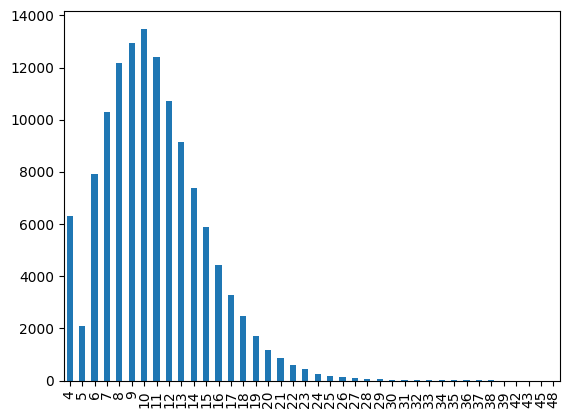

In [162]:
heights = pd.Series(heights).sort_index()
heights.plot(kind='bar')

In [163]:
heights_df = heights.to_frame('n')
heights_df['frac'] = heights_df['n'] / heights.sum()
heights_df['cuml_frac'] = heights_df['frac'].cumsum()
heights_df[heights_df['cuml_frac'] > 0.95].index.min()

np.int64(18)

In [164]:
len(ontn_sentc_tree_prc32)

126566

In [165]:
ontn_sentc_tree_fin = []
for i, sent in enumerate(ontn_sentc_tree_prc32):
    if sent['height'] < 18:
        ontn_sentc_tree_fin.append(sent)

In [166]:
len(ontn_sentc_tree_fin)

118495

# Add levels to non-terminal 

In [167]:
def add_levels(tree: Tree) -> Tree:
    tps = tree.treepositions('leaves')
    for tp in tps:
        branch_height = len(tp)
        tp_list = list(tp)
        for i in range(branch_height):
            idx = tuple(tp_list[:i+1]) 
            if tree[idx].height() == 2:  # if it is (Non-term Term), we don't add level to Non-term
                break
            act_label = tree[idx].label()  # actual label
            if not act_label[-1].isdigit():
                tree[idx].set_label(f"{act_label}_{i}")
    return tree

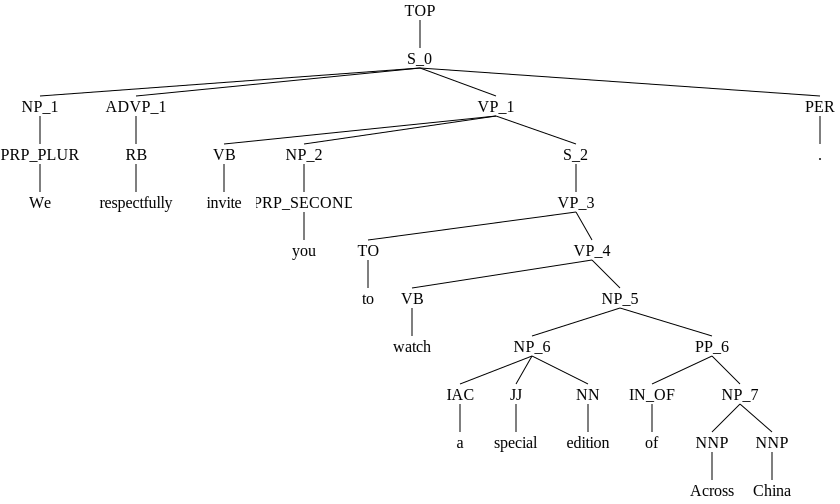

In [168]:
sent = ontn_sentc_tree_fin[1]
tree = Tree.fromstring(sent['parse_tree'])

add_levels(tree)

# Get all productions like a DICT

In [169]:
def process_chunk(chunk: List[Dict]) -> Dict:
    local_dict = {}
    for elem in chunk:
        tree = add_levels(Tree.fromstring(elem['parse_tree']))
        for prod in tree.productions():
            lhs = prod.lhs()
            rhs = prod.rhs()
            if lhs in local_dict:
                if rhs not in local_dict[lhs]:
                    local_dict[lhs].append(rhs)
            else:
                local_dict[lhs] = [rhs]
    return local_dict

def merge_dicts(dict_list: List[Dict]) -> Dict:
    merged = {}
    for local_dict in dict_list:
        for lhs, rhs_list in local_dict.items():
            if lhs not in merged:
                merged[lhs] = []
            existing_rhs = merged[lhs]
            for rhs in rhs_list:
                if rhs not in existing_rhs:
                    existing_rhs.append(rhs)
    return merged

In [170]:
num_processes = multiprocessing.cpu_count()
num_processes

16

In [171]:
# total_elements = len(ontn_sentc_tree_fin)
# chunk_size = max(1, total_elements // num_processes)
# chunks = [ontn_sentc_tree_fin[i:i+chunk_size] for i in range(0, total_elements, chunk_size)]

# with multiprocessing.Pool(processes=num_processes) as pool:
#     chunk_dicts = pool.map(process_chunk, chunks)

# productions_dict = merge_dicts(chunk_dicts)

In [172]:
productions_dict: Dict[str, Optional[List[str]]] = dict()
for elem in tqdm(ontn_sentc_tree_fin):
    tree = add_levels(Tree.fromstring(elem['parse_tree']))

    for prod in tree.productions():
        if prod.lhs() in productions_dict.keys():
            if prod.rhs() in productions_dict[prod.lhs()]:
                pass
            else:
                productions_dict[prod.lhs()].append(prod.rhs())
        else:
            productions_dict[prod.lhs()] = [prod.rhs()]

100%|██████████| 118495/118495 [03:38<00:00, 542.24it/s] 


In [173]:
productions_dict.keys()

dict_keys([TOP, SBARQ_0, WHNP_1, WHNP_2, WP_WHAT, NN, PP_2, IN_OF, NP_3, QM, S_0, NP_1, PRP_PLUR, ADVP_1, RB, VP_1, VB, NP_2, PRP_SECOND, S_2, VP_3, TO, VP_4, NP_5, NP_6, IAC, JJ, PP_6, NP_7, NNP, PER, SINV_0, VBG, ADJP_3, IN_ON, VBZ_IS, DA, IN_TO, NML_4, NNPS, PRP_THIRD, VP_2, VBN, PP_3, NP_4, CMA, NNS, NML_6, NML_7, AND, PP_5, IN, NP_0, CD, NML_2, VBD_WAS, PP_4, JJS, IN_BY, NP_8, PP_8, IN_AGAINST, NP_9, DT, VBD, IN_THROUGH, POS, PRT_5, RP, ADVP_6, SBAR_3, WHADVP_4, WRB, S_4, VP_5, VP_6, ADVP_7, RB_BACK, RB_THEN, PP_1, NML_5, IN_AT, IN_IN, SBAR_2, WHADVP_3, IN_THAT, S_3, SBAR_6, S_7, VP_8, ADVP_9, VP_9, NP_10, PP_10, IN_INTO, NP_11, NP_12, PP_12, NP_13, IN_FROM, IAV, INTJ_1, UH, MD_COULD, ADVP_2, MD_WOULD, INTJ_2, IN_AS, RB_SO, IN_WITH, ADJP_2, RB_VERY, ADVP_3, VBD_HAD, PRP_DLR, NML_3, VBD_WERE, ADJP_6, JJR, IN_FOR, PP_7, ADJP_5, SBAR_5, S_6, VP_7, PP_9, S_5, NML_10, HYPH, IN_BEFORE, INTJ_5, ADJP_4, PRT_7, IN_UNDER, ADVP_4, RBR, INTJ_0, IN_AFTER, NML_8, SQ_1, S_1, RB_ALSO, WHNP_4, WDT

# Remove NNP and NNPs which intersect with other terminals

In [174]:
nnp_set = set(productions_dict[Nonterminal('NNP')])
nnps_set = set(productions_dict[Nonterminal('NNPS')])
print('Count of NNP', len(nnp_set))
print('Count of NNPS', len(nnps_set))
for nt_name in productions_dict.keys():
    if str(nt_name) not in ('TOP', 'NNP', 'NNPS') and not str(nt_name)[-1].isdigit():
        nnp_set = nnp_set - set(productions_dict[Nonterminal(str(nt_name))])
        nnps_set = nnps_set - set(productions_dict[Nonterminal(str(nt_name))])

print('Count of NNP after cleaning', len(nnp_set))
print('Count of NNPS after cleaning', len(nnps_set))
productions_dict[Nonterminal('NNP')] = list(nnp_set)
productions_dict[Nonterminal('NNPS')] = list(nnps_set)

Count of NNP 18346
Count of NNPS 1029
Count of NNP after cleaning 15980
Count of NNPS after cleaning 661


# Productions dict to grammar

## To JSON

In [175]:
from collections import defaultdict

In [176]:
ALL_RHS = list(productions_dict.keys())
prod_to_json = defaultdict(list)
for lhs in tqdm(ALL_RHS):
    left = str(lhs)
    for i, rhs_tuple in enumerate(productions_dict[lhs]):
        right = ""
        for rhs in rhs_tuple:
            if isinstance(rhs, Nonterminal):
                # prod_to_json[left].append(str(rhs))
                right += str(rhs) + " "
            else:
                prod_to_json[left].append('\"' + rhs + '\"')
        if right != "":
            prod_to_json[left].append(right.strip())

100%|██████████| 467/467 [00:00<00:00, 2665.66it/s]


In [177]:
import json

In [178]:
with open('ontonotesv5_gram.json', 'w') as f:
    json.dump(prod_to_json, f, indent=4)